In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### В этом ноутбуке будет исследован датасет с обезличенными данными о клиентах телекома и построены модели классификации для предсказания оттока
### В качестве метрики качества будет использован f1-score


### Содержание:

## 1. EDA
- [Исследование категориальных признаков](#Исследование-категориальных-признаков)
- [Исследование числовых признаков](#Исследование-числовых-признаков)

 [Итоговый-препроцессинг](#Итоговый-препроцессинг)


## 2. Базовая модель и baseline
- [Обучение базовой модели и получение baseline](#Обучение-базовой-модели-и-получение-baseline)


## 3. Улучшение модели
- [Подбор трешхолда для базовой модели](#Подберем-трешхолд-для-базовой-модели)
- [Подбор гиперпараметров для базовой модели с помощью Optuna](#Подбор-гиперпараметров-c-помощью-Optuna)


## 4. [Другой подход к подбору и предобработке признаков](#Другой-подход-к-препроцессингу)
- [Обучение модели](#Теперь-возьмем-ту-же-базовую-модель,-обучимся-на-тех-же-объектах,-но-других-признаках-и-посмотрим-результат)
- [Подбор гиперпараметров](#Подберем-гиперпараметры)


## 5. [Заключение](#Заключение)


# EDA

Загружаем датасет

In [3]:
train_df = pd.read_csv('C:/Users/IOKravchenko/Downloads/teta_ml/train_cut.csv')
train_df = train_df.drop(columns='Unnamed: 0')
train_df = train_df.drop(columns='client_id', axis=1) #сразу удалим id клиента
train_df_2 = train_df #копия датафрейма понадобится в дальнейшей работе

#### Общая инфо о датасете

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   регион              60826 non-null   object 
 1   использование       100000 non-null  object 
 2   сумма               65016 non-null   float64
 3   частота_пополнения  65016 non-null   float64
 4   доход               66449 non-null   float64
 5   сегмент_arpu        66449 non-null   float64
 6   частота             66449 non-null   float64
 7   объем_данных        51065 non-null   float64
 8   on_net              63492 non-null   float64
 9   продукт_1           58540 non-null   float64
 10  продукт_2           40120 non-null   float64
 11  зона_1              7932 non-null    float64
 12  зона_2              6387 non-null    float64
 13  mrg_                100000 non-null  bool   
 14  секретный_скор      100000 non-null  float64
 15  pack                58363 non-null 

#### Число пропусков

In [5]:
train_df.isna().sum()

регион                39174
использование             0
сумма                 34984
частота_пополнения    34984
доход                 33551
сегмент_arpu          33551
частота               33551
объем_данных          48935
on_net                36508
продукт_1             41460
продукт_2             59880
зона_1                92068
зона_2                93613
mrg_                      0
секретный_скор            0
pack                  41637
pack_freq             41637
binary_target             0
dtype: int64

In [6]:
train_df['binary_target'].value_counts()

binary_target
0    81362
1    18638
Name: count, dtype: int64

**Наблюдаем дисбаланс классов в таргете**

### Матрица корреляций для числовых признаков

In [7]:
cor_cols = train_df.select_dtypes(exclude=['object', 'bool']).columns

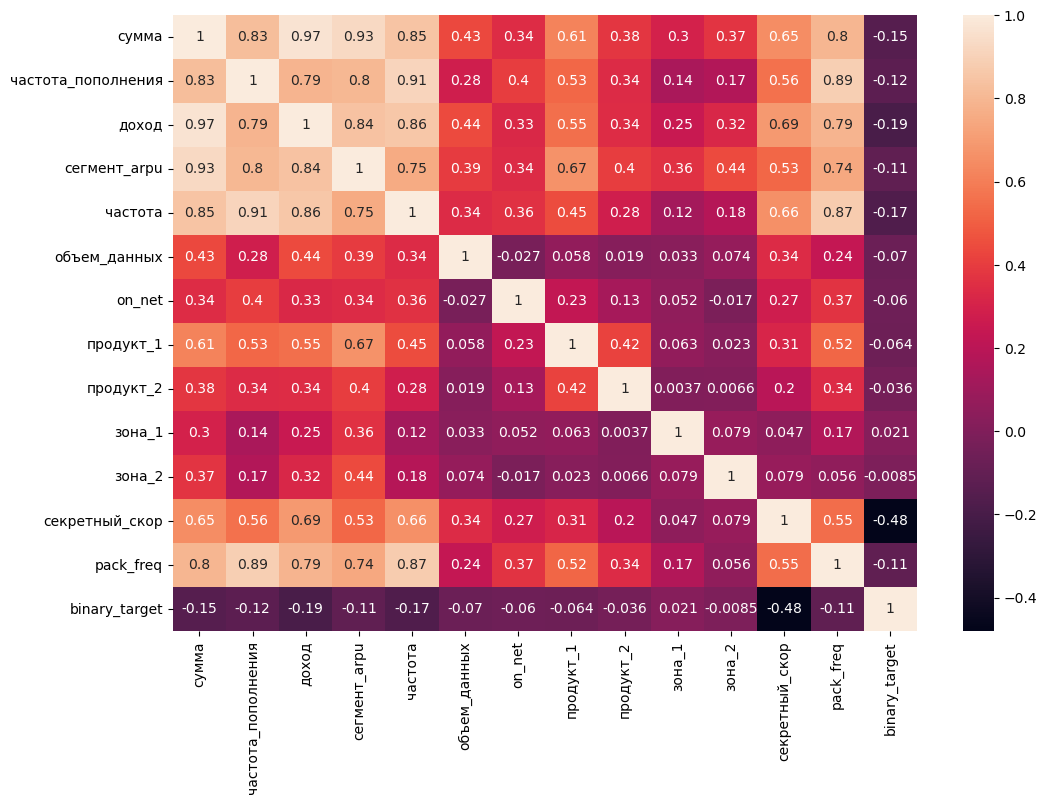

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(train_df[cor_cols].corr(), annot=True)
plt.show()

### Матрица корреляций для категориальных признаков

In [9]:
# pip install association-metrics

In [10]:
import association_metrics as am

In [11]:
train_df_c = train_df.apply(lambda x: x.astype('category') if x.dtype == 'object' else x)
train_df_c['binary_target'] = train_df['binary_target'].astype('category')

<Axes: >

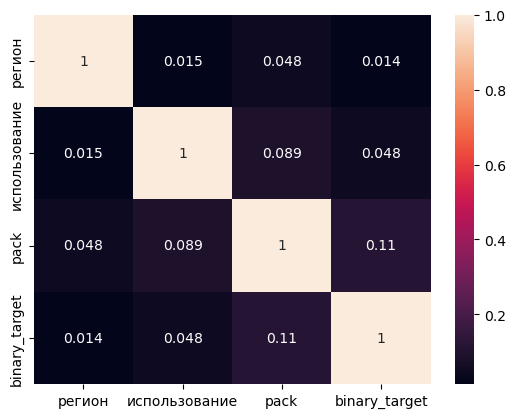

In [12]:
cramer = am.CramersV(train_df_c)
sns.heatmap(cramer.fit(), annot = True)

#### Видим, что категориальные фичи имеют низкую корреляцию с таргетом

# Исследование категориальных признаков

In [13]:
train_df.select_dtypes(include = 'object').columns

Index(['регион', 'использование', 'pack'], dtype='object')

In [14]:
train_df['mrg_'].value_counts()

mrg_
False    100000
Name: count, dtype: int64

**Единственный bool столбец содержит только одно значение - его можно удалить**

## Регион

In [15]:
print('количество пропусков:', train_df['регион'].isna().sum())
print('доля пропусков:', train_df['регион'].isna().sum() / len(train_df['регион']))

количество пропусков: 39174
доля пропусков: 0.39174


In [16]:
train_df['регион'] = train_df['регион'].fillna('unknown')
train_df['регион'].value_counts()

регион
unknown     39174
Марс        23882
Земля        8449
Юпитер       5454
Нептун       4584
Венера       4561
Сатурн       3181
Солнце       2579
Меркурий     2035
Уран         1800
Хаумеа       1680
Церера       1392
Плутон       1023
Макемаке      150
Эрида          56
Name: count, dtype: int64

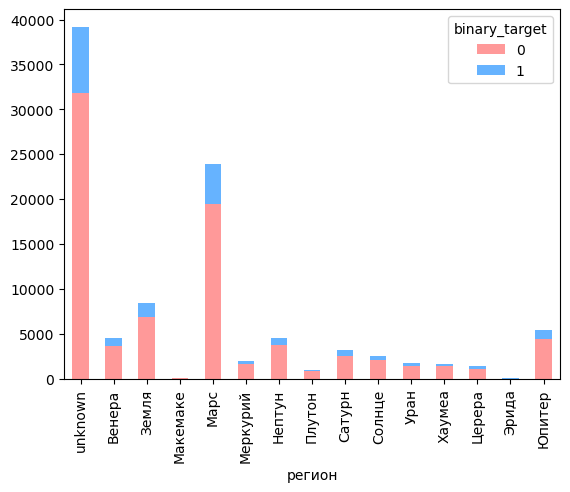

In [17]:
counts = train_df.groupby(['регион', 'binary_target']).size().unstack(fill_value=0)

counts.plot(kind='bar', stacked=True, color=['#FF9999', '#66B3FF'])
plt.show()

In [18]:
counts.loc[:, 0] / (counts.loc[:, 0] + counts.loc[:, 1] )

регион
unknown     0.812350
Венера      0.805964
Земля       0.817020
Макемаке    0.800000
Марс        0.814002
Меркурий    0.811302
Нептун      0.814791
Плутон      0.826002
Сатурн      0.813895
Солнце      0.811167
Уран        0.802222
Хаумеа      0.827381
Церера      0.827586
Эрида       0.732143
Юпитер      0.817932
dtype: float64

#### Видим, что доля 1 и 0 в регионах одинаковая, что дает нам мало информации из этого признака

## Использование

In [19]:
print('количество пропусков:', train_df['использование'].isna().sum())
print('доля пропусков:', train_df['использование'].isna().sum() / len(train_df['использование']))

количество пропусков: 0
доля пропусков: 0.0


In [20]:
train_df['использование'] = train_df['использование'].fillna('unknown')
train_df['использование'].value_counts()

использование
>24LY      94711
18_21LY     2104
15_18LY     1260
12_15LY      746
21_24LY      609
9_12LY       437
6_9LY         99
3_6LY         34
Name: count, dtype: int64

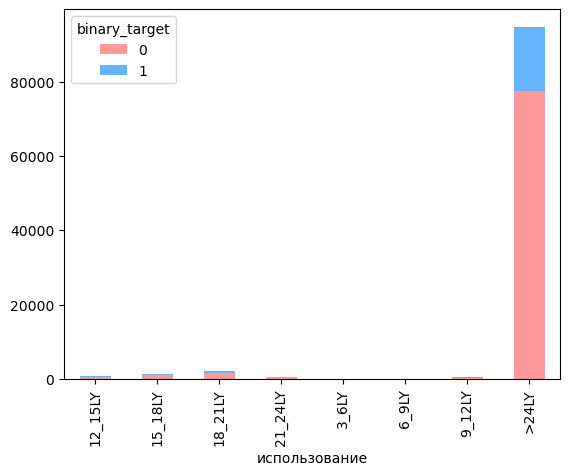

In [21]:
counts = train_df.groupby(['использование', 'binary_target']).size().unstack(fill_value=0)

counts.plot(kind='bar', stacked=True, color=['#FF9999', '#66B3FF'])
plt.show()

In [22]:
counts.loc[:, 0] / (counts.loc[:, 0] + counts.loc[:, 1] )

использование
12_15LY    0.680965
15_18LY    0.756349
18_21LY    0.732414
21_24LY    0.783251
3_6LY      0.970588
6_9LY      0.828283
9_12LY     0.775744
>24LY      0.817529
dtype: float64

### Очень сильно преобладает категория ">24LY"
**разделим этот столбец на >24LY и "other"**

In [23]:
train_df["использование"] = train_df["использование"].apply(lambda x: x if x == ">24LY" else "other")

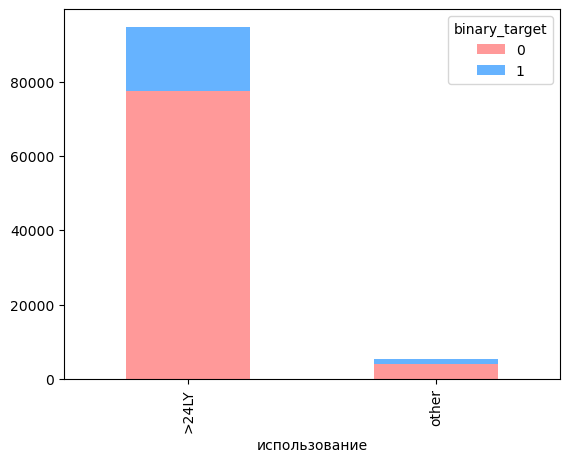

In [24]:
counts = train_df.groupby(['использование', 'binary_target']).size().unstack(fill_value=0)

counts.plot(kind='bar', stacked=True, color=['#FF9999', '#66B3FF'])
plt.show()

## pack

In [25]:
print('количество пропусков:', train_df['pack'].isna().sum())
print('доля пропусков:', train_df['pack'].isna().sum() / len(train_df['pack']))

количество пропусков: 41637
доля пропусков: 0.41637


In [26]:
train_df['pack'] = train_df['pack'].fillna('unknown_2')

pd.set_option('display.max_rows', None)
train_df['pack'].value_counts().to_frame()

,count
pack,
unknown_2,41637
_output-_сеть 500 (условие) 2000f;5d,14853
input__ _сеть 200 (условие) _безлим _c_output_сутки,6972
"трафик:490 (условие) 1gb,7d",5461
"трафик: 100 (условие) 40mb,_сутки",3921
тариф_a 250 (условие) _безлим_c_output_сутки,3070
тариф_a:500 (условие) 2500f input__ _сеть _2500f off _сеть;2d,2967
"трафик:1000 (условие) 2gb,-месяц",2803
_output-_сеть 500f =2000f__output_сеть__безлим,2239


In [27]:
pd.set_option('display.max_rows', 10)

### Видим много пропусков и уникальных значений
**Пропуски заменим на unknown_2**

In [28]:
# pack_df = train_df['pack'].value_counts().to_frame()

In [29]:
# pack_df['quantile_binned'] = pd.qcut(pack_df['count'], q=8)
# pack_df['binned_code'] = pack_df['quantile_binned'].cat.codes + 1

In [30]:
counts = train_df.groupby(['pack', 'binary_target']).size().unstack(fill_value=0)

In [31]:
counts['churn_proc'] = counts.loc[:, 1] / (counts.loc[:, 0] + counts.loc[:, 1] ) 

In [32]:
pd.set_option('display.max_rows', None)
counts.sort_values('churn_proc')

binary_target,0,1,churn_proc
pack,,,
-пилот_youth1_290,18,0,0.000000
fnf2 ( роуминг ),9,0,0.000000
gprs_3000equal10gportal,2,0,0.000000
input__-_сеть 300 (условие) 1800f;3d,41,0,0.000000
internat: 1000f_zinput__e_3;_сутки,1,0,0.000000
internat: 2000f_zinput__e_2;_сутки,5,0,0.000000
ivr чат _minput__ сотый _500f,1,0,0.000000
ivr чат _weekly_200f,1,0,0.000000
mromo_соц_input__e-день,29,0,0.000000


In [33]:
pd.set_option('display.max_rows', 10)

**есть тарифы с вероятностью оттока меньше 5%, добавим этот флаг low_churn_pack**  
**также для всех тарифов применим TargetEncoder**

In [34]:
#pip install category_encoders

In [35]:
from category_encoders import TargetEncoder

In [36]:
low_churn_pack = counts[counts['churn_proc'] < 0.05].index

In [37]:
train_df['low_churn_pack'] = train_df['pack'].isin(low_churn_pack).astype(int)

In [38]:
Targetenc = TargetEncoder().fit(X = train_df["pack"], y = train_df['binary_target'])

train_df['pack'] = Targetenc.transform(X = train_df["pack"])

## Исследование числовых признаков

**Общие сведения**

In [39]:
train_df.select_dtypes(exclude='object').describe()

,Unnamed: 0,сумма,частота_пополнения,доход,сегмент_arpu,частота,объем_данных,on_net,продукт_1,продукт_2,зона_1,зона_2,секретный_скор,pack,pack_freq,binary_target,low_churn_pack
count,1.000000e+05,65016.000000,65016.000000,66449.000000,66449.000000,66449.000000,51065.000000,63492.000000,58540.000000,40120.000000,7932.000000,6387.000000,100000.000000,100000.000000,58363.000000,100000.000000,100000.00000
mean,5.042579e+05,41.481476,11.529162,42868.636864,786.355121,3.279827,34.229614,273.716956,95.729108,23.038883,0.001579,0.249353,0.444433,0.186745,2.598919,0.186380,0.40034
std,2.917727e+05,25.388106,13.266917,14460.052169,1034.891966,1.792443,47.209243,854.275030,202.962049,62.064497,0.007044,0.922493,0.365587,0.175235,1.579258,0.389415,0.48997
min,0.000000e+00,4.528797,1.000000,5726.010183,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000057,1.000000,0.000000,0.00000
25%,2.511152e+05,20.672445,2.000000,32149.996445,142.310000,1.732051,0.000000,5.000000,7.000000,2.000000,0.000000,0.000000,0.081967,0.030566,1.414214,0.000000,0.00000
50%,5.044275e+05,35.805726,7.000000,42311.774838,427.350000,3.000000,16.062378,27.000000,29.000000,6.000000,0.000209,0.063633,0.377049,0.059854,2.236068,0.000000,0.00000
75%,7.567912e+05,56.044893,16.000000,52995.539379,1051.710000,4.472136,53.357286,156.000000,99.000000,21.000000,0.000626,0.159084,0.819672,0.393280,3.464102,0.000000,1.00000
max,1.010245e+06,333.012672,131.000000,129843.989985,37898.720000,9.539392,1151.900603,24895.000000,5592.000000,2899.000000,0.184265,18.612790,1.000000,0.393280,25.079872,1.000000,1.00000


### сумма

In [40]:
print('количество пропусков:', train_df['сумма'].isna().sum())
print('доля пропусков:', train_df['сумма'].isna().sum() / len(train_df['регион']))

количество пропусков: 34984
доля пропусков: 0.34984


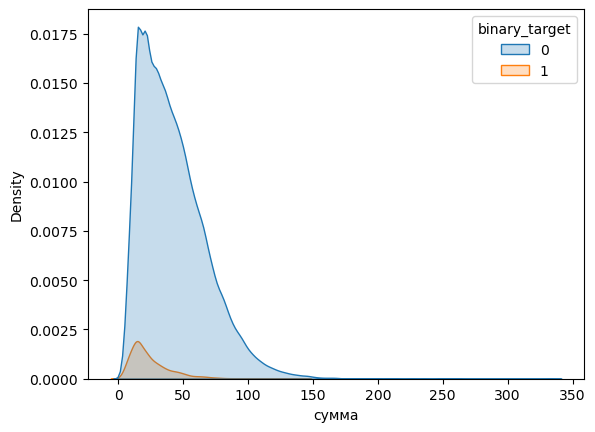

In [41]:
sns.kdeplot(x=train_df['сумма'], hue=train_df['binary_target'], fill=True)
plt.show()

**Видим, что с увеличением суммы уменьшается вероятность оттока  
Заполним пропуски медианой**

## частота_пополнения

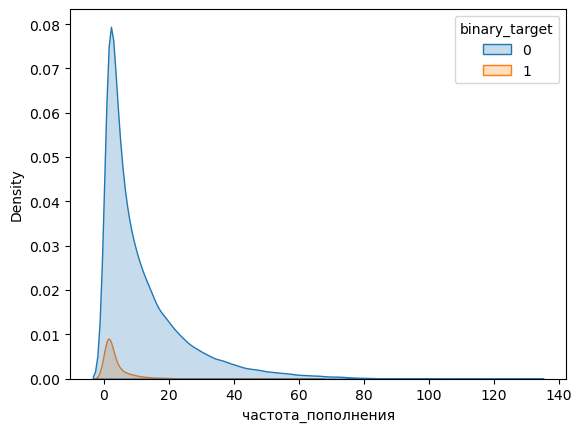

количество пропусков: 34984
доля пропусков: 0.34984


In [42]:
sns.kdeplot(x=train_df['частота_пополнения'], hue=train_df['binary_target'], fill=True)
plt.show()

print('количество пропусков:', train_df['частота_пополнения'].isna().sum())
print('доля пропусков:', train_df['частота_пополнения'].isna().sum() / len(train_df['регион']))

**Пропуски заполним медианой**

**Распределение признака визуально совпадает с таргетом**

## доход

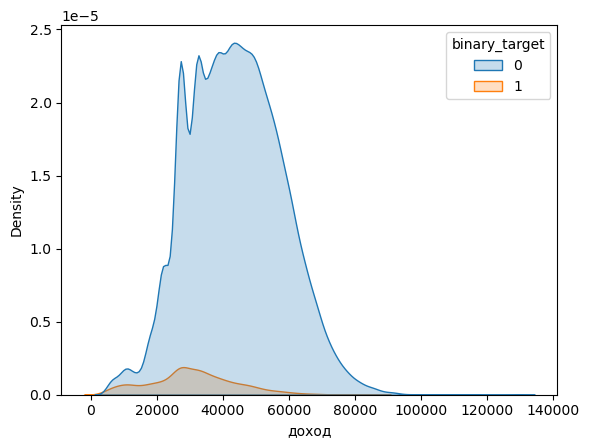

количество пропусков: 33551
доля пропусков: 0.33551


In [43]:
sns.kdeplot(x=train_df['доход'], hue=train_df['binary_target'], fill=True)
plt.show()
print('количество пропусков:', train_df['доход'].isna().sum())
print('доля пропусков:', train_df['доход'].isna().sum() / len(train_df['регион']))

## сегмент_arpu

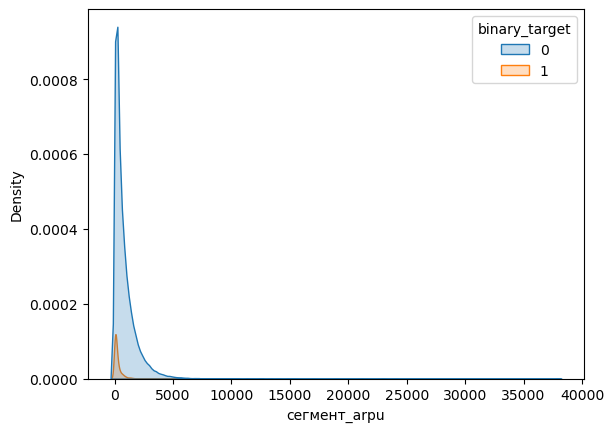

количество пропусков: 33551
доля пропусков: 0.33551


In [44]:
sns.kdeplot(x=train_df['сегмент_arpu'], hue=train_df['binary_target'], fill=True)
plt.show()
print('количество пропусков:', train_df['сегмент_arpu'].isna().sum())
print('доля пропусков:', train_df['сегмент_arpu'].isna().sum() / len(train_df['регион']))

**Распределение признака совпадает с таргетом**

## частота

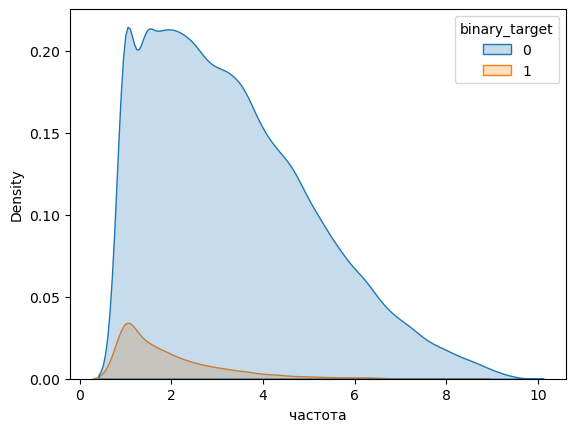

количество пропусков: 33551
доля пропусков: 0.33551


In [45]:
sns.kdeplot(x=train_df['частота'], hue=train_df['binary_target'], fill=True)
plt.show()
print('количество пропусков:', train_df['частота'].isna().sum())
print('доля пропусков:', train_df['частота'].isna().sum() / len(train_df['регион']))

**распределение признака и таргета имеют разную форму**

### объем_данных

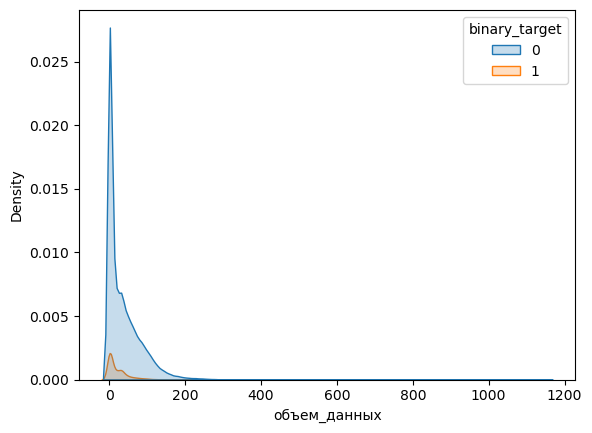

количество пропусков: 48935
доля пропусков: 0.48935


In [46]:
sns.kdeplot(x=train_df['объем_данных'], hue=train_df['binary_target'], fill=True)
plt.show()
print('количество пропусков:', train_df['объем_данных'].isna().sum())
print('доля пропусков:', train_df['объем_данных'].isna().sum() / len(train_df['регион']))

## on_net

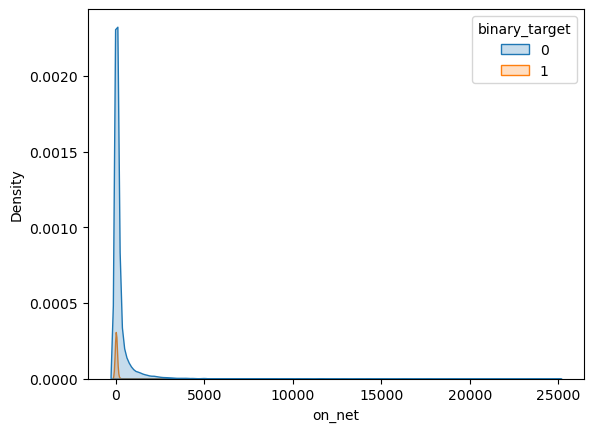

количество пропусков: 36508
доля пропусков: 0.36508


In [47]:
sns.kdeplot(x=train_df['on_net'], hue=train_df['binary_target'], fill=True)
plt.show()
print('количество пропусков:', train_df['on_net'].isna().sum())
print('доля пропусков:', train_df['on_net'].isna().sum() / len(train_df['регион']))

**Признак имеет выбросы**

**Признаки продукт_1, продукт_2, зона_1, зона_2 имеют очень большое количество пропусков а также очень маленькую корреляцию с таргетом, так что их счиатем неинформативными**

## Итоговый препроцессинг

**Помимо основных фичей, добавим также еще одну новую - количество пропусков в данных для объекта**

In [48]:
train_df['null_count'] = train_df.isnull().sum(axis=1)

In [49]:
from sklearn.preprocessing import TargetEncoder

In [50]:
# %%time
# train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

# train_df = train_df

# train_df = train_df.drop(columns = 'client_id', axis=1)

**Расчет для ['low_churn_pack']**

In [51]:
counts = train_df.groupby(['pack', 'binary_target']).size().unstack(fill_value=0)
counts['churn_proc'] = counts.loc[:, 1] / (counts.loc[:, 0] + counts.loc[:, 1] )
low_churn_pack = counts[counts['churn_proc'] < 0.05].index
train_df['low_churn_pack'] = train_df['pack'].isin(low_churn_pack).astype(int)

In [52]:
Targetenc = TargetEncoder().fit(X = train_df[['pack']], y = train_df['binary_target'])

**Функция для препроцессинга**

In [53]:
def preproc(data):
    data['null_count'] = data.isnull().sum(axis=1)

    data['регион'] = data['регион'].fillna('unknown_reg')

    data['использование'] = data['использование'].fillna('unknown_use')
    data["использование"] = data["использование"].apply(lambda x: x if x == ">24LY" else "other")

    # заполнение nan в столбце pack и обработка таргет энкодером
    data['pack'] = data['pack'].fillna('unknown_2')
    #Targetenc = TargetEncoder().fit(X = train_df['pack'], y = train_df['binary_target'])
    data['pack'] = Targetenc.transform(X = data[['pack']])

    # добавление флага low_churn_pack
    data['low_churn_pack'] = data['pack'].isin(low_churn_pack).astype('int64')


    #заполнение медианой числовых признаков
    median_cols = ['сумма', 'частота_пополнения', 'доход', 'частота', 'объем_данных', 'on_net']
    
    for col in median_cols:
        data[col] = data[col].fillna(data[col].median())
#     train_df['сумма'] = train_df['сумма'].fillna(train_df['сумма'].median())
#     train_df['частота_пополнения'] = train_df['частота_пополнения'].fillna(train_df['частота_пополнения'].median())
#     train_df['доход'] = train_df['доход'].fillna(train_df['доход'].median())
#     train_df['частота'] = train_df['частота'].fillna(train_df['частота'].median())
#     train_df['on_net'] = train_df['on_net'].fillna(train_df['доход'].median())

**Отберем колонки в датасет для обучения**

In [54]:
model_cols = ['регион', 'использование', 'pack', 'low_churn_pack',
              'сумма', 'частота_пополнения', 'доход', 'частота',  'объем_данных', 'on_net', 'null_count', 'секретный_скор']
cat_cols = ['low_churn_pack', 'регион', 'использование']

In [55]:
col=['регион', 'использование', 'сумма', 'частота_пополнения', 
       'доход', 'сегмент_arpu', 'частота',
       'объем_данных', 'on_net',
       'продукт_1', 'продукт_2', 'секретный_скор', 'pack_freq', 'null_count']

# Обучение базовой модели и получение baseline

In [56]:
train_df = pd.read_csv('C:/Users/IOKravchenko/Downloads/teta_ml/train_cut.csv')
#train_df = train_df.drop(columns='Unnamed: 0')
train_df = train_df.drop(columns='client_id', axis=1) #сразу удалим id клиента
# train_df_2 = train_df #копия датафрейма понадобится в дальнейшей работе
train_df['null_count'] = train_df.isnull().sum(axis=1)

In [57]:
preproc(train_df)

In [58]:
X = train_df[model_cols]
y = train_df['binary_target']

In [59]:
X.head(3)

,регион,использование,pack,low_churn_pack,сумма,частота_пополнения,доход,частота,объем_данных,on_net,null_count,секретный_скор
0,unknown_reg,>24LY,0.18638,0,47.366549,18.0,49344.054590,5.099020,25.670995,113.0,3,0.540984
1,unknown_reg,>24LY,0.18638,0,29.957303,13.0,37321.597603,3.872983,16.062378,7.0,6,0.639344
2,Нептун,>24LY,0.18638,0,65.372012,20.0,57665.518427,4.582576,0.000000,204.0,3,0.885246


In [60]:
base_model = CatBoostClassifier(cat_features=cat_cols,
                                learning_rate = 0.1,
                                depth = 8,
                                l2_leaf_reg=2,
                                early_stopping_rounds=50, iterations=200)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

In [62]:
base_model.fit(X_train, y_train)

0:	learn: 0.5924411	total: 204ms	remaining: 40.5s
1:	learn: 0.5141119	total: 253ms	remaining: 25s
2:	learn: 0.4574208	total: 303ms	remaining: 19.9s
3:	learn: 0.4160720	total: 353ms	remaining: 17.3s
4:	learn: 0.3838777	total: 403ms	remaining: 15.7s
5:	learn: 0.3624094	total: 457ms	remaining: 14.8s
6:	learn: 0.3473965	total: 506ms	remaining: 13.9s
7:	learn: 0.3358597	total: 552ms	remaining: 13.2s
8:	learn: 0.3274100	total: 600ms	remaining: 12.7s
9:	learn: 0.3203341	total: 647ms	remaining: 12.3s
10:	learn: 0.3143298	total: 703ms	remaining: 12.1s
11:	learn: 0.3104018	total: 749ms	remaining: 11.7s
12:	learn: 0.3065288	total: 798ms	remaining: 11.5s
13:	learn: 0.3042474	total: 846ms	remaining: 11.2s
14:	learn: 0.3025201	total: 898ms	remaining: 11.1s
15:	learn: 0.3009633	total: 951ms	remaining: 10.9s
16:	learn: 0.2997176	total: 1.01s	remaining: 10.8s
17:	learn: 0.2988964	total: 1.06s	remaining: 10.7s
18:	learn: 0.2982181	total: 1.08s	remaining: 10.3s
19:	learn: 0.2975532	total: 1.13s	remaining

164:	learn: 0.2789963	total: 7.79s	remaining: 1.65s
165:	learn: 0.2789365	total: 7.84s	remaining: 1.6s
166:	learn: 0.2789087	total: 7.88s	remaining: 1.56s
167:	learn: 0.2787618	total: 7.93s	remaining: 1.51s
168:	learn: 0.2786695	total: 7.99s	remaining: 1.47s
169:	learn: 0.2786502	total: 8.05s	remaining: 1.42s
170:	learn: 0.2785651	total: 8.1s	remaining: 1.37s
171:	learn: 0.2783237	total: 8.15s	remaining: 1.33s
172:	learn: 0.2782174	total: 8.2s	remaining: 1.28s
173:	learn: 0.2781442	total: 8.24s	remaining: 1.23s
174:	learn: 0.2780753	total: 8.29s	remaining: 1.18s
175:	learn: 0.2780697	total: 8.32s	remaining: 1.14s
176:	learn: 0.2780475	total: 8.37s	remaining: 1.09s
177:	learn: 0.2778890	total: 8.41s	remaining: 1.04s
178:	learn: 0.2777974	total: 8.46s	remaining: 993ms
179:	learn: 0.2776890	total: 8.51s	remaining: 945ms
180:	learn: 0.2775768	total: 8.55s	remaining: 898ms
181:	learn: 0.2774987	total: 8.6s	remaining: 851ms
182:	learn: 0.2774781	total: 8.64s	remaining: 803ms
183:	learn: 0.27

In [63]:
preds = base_model.predict(X_test)
base_f1 = f1_score(y_test, preds)
base_f1

0.6078731129371298

**Базово получаем f1-score равный: 0.6078731129371298 на тесте, что уже хорошо для данной задачи с учетом количества пропусков в данных**

**Посмотрим, какие веса имеют признаки**

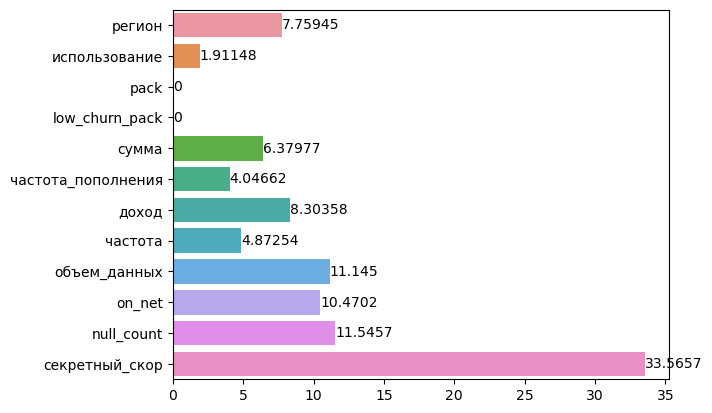

In [64]:
ax = sns.barplot(x=base_model.get_feature_importance(), y=X.columns)
ax.bar_label(ax.containers[0], fontsize=10);

**Как видим, признаки 'low_churn_pack'  и 'pack' являются неинформативными**

In [65]:
X = train_df[model_cols]
y = train_df['binary_target']
X = X.drop(columns='low_churn_pack', axis=1)
cat_cols = ['регион', 'использование']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

In [67]:
base_model = CatBoostClassifier(cat_features=cat_cols,
                                learning_rate = 0.1,
                                depth = 8,
                                l2_leaf_reg=2,
                                early_stopping_rounds=50, iterations=200)

In [68]:
base_model.fit(X_train, y_train)

0:	learn: 0.5924411	total: 38.2ms	remaining: 7.6s
1:	learn: 0.5141119	total: 87.5ms	remaining: 8.67s
2:	learn: 0.4574208	total: 137ms	remaining: 8.97s
3:	learn: 0.4160720	total: 186ms	remaining: 9.09s
4:	learn: 0.3838777	total: 237ms	remaining: 9.24s
5:	learn: 0.3624094	total: 290ms	remaining: 9.39s
6:	learn: 0.3473965	total: 341ms	remaining: 9.4s
7:	learn: 0.3358597	total: 390ms	remaining: 9.36s
8:	learn: 0.3274100	total: 439ms	remaining: 9.31s
9:	learn: 0.3203341	total: 493ms	remaining: 9.37s
10:	learn: 0.3143298	total: 540ms	remaining: 9.27s
11:	learn: 0.3104018	total: 587ms	remaining: 9.19s
12:	learn: 0.3065288	total: 635ms	remaining: 9.13s
13:	learn: 0.3042474	total: 682ms	remaining: 9.06s
14:	learn: 0.3025201	total: 740ms	remaining: 9.13s
15:	learn: 0.3009633	total: 786ms	remaining: 9.04s
16:	learn: 0.2997176	total: 834ms	remaining: 8.98s
17:	learn: 0.2988964	total: 881ms	remaining: 8.9s
18:	learn: 0.2982181	total: 904ms	remaining: 8.61s
19:	learn: 0.2975532	total: 955ms	remainin

163:	learn: 0.2790901	total: 7.73s	remaining: 1.7s
164:	learn: 0.2789963	total: 7.78s	remaining: 1.65s
165:	learn: 0.2789365	total: 7.83s	remaining: 1.6s
166:	learn: 0.2789087	total: 7.87s	remaining: 1.55s
167:	learn: 0.2787618	total: 7.92s	remaining: 1.51s
168:	learn: 0.2786695	total: 7.97s	remaining: 1.46s
169:	learn: 0.2786502	total: 8.01s	remaining: 1.41s
170:	learn: 0.2785651	total: 8.06s	remaining: 1.37s
171:	learn: 0.2783237	total: 8.1s	remaining: 1.32s
172:	learn: 0.2782174	total: 8.15s	remaining: 1.27s
173:	learn: 0.2781442	total: 8.19s	remaining: 1.22s
174:	learn: 0.2780753	total: 8.24s	remaining: 1.18s
175:	learn: 0.2780697	total: 8.27s	remaining: 1.13s
176:	learn: 0.2780475	total: 8.31s	remaining: 1.08s
177:	learn: 0.2778890	total: 8.36s	remaining: 1.03s
178:	learn: 0.2777974	total: 8.41s	remaining: 987ms
179:	learn: 0.2776890	total: 8.47s	remaining: 941ms
180:	learn: 0.2775768	total: 8.51s	remaining: 894ms
181:	learn: 0.2774987	total: 8.56s	remaining: 847ms
182:	learn: 0.2

### Подберем трешхолд для базовой модели

In [69]:
from tqdm import tqdm

thresholds = np.arange(0.1, 0.9, 0.01)

f1_list = []
for threshold in tqdm(thresholds):
    predicted = (base_model.predict_proba(X_train)[:, 1] > threshold)
    
    f1 = f1_score(y_train, predicted)
    f1_list.append(f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 16.69it/s]


In [70]:
df = pd.DataFrame(list(zip(thresholds, f1_list)), columns=['Treshold', 'F1-Score'])
df[df['F1-Score'] == df['F1-Score'].max()]

,Treshold,F1-Score
22,0.32,0.669424


In [71]:
thld = round(df[df['F1-Score'] == df['F1-Score'].max()]['Treshold'].values[0], 3)
thld

0.32

**Проверим f1-score на тестовой выборке после подбора трешхолда** 

In [72]:
predicted = np.where(base_model.predict_proba(X_test)[:, 1] > thld, 1 , 0)
base_f1_tshld = f1_score(y_test, predicted)

In [73]:
print('f1-score на тесте до подбора порога   :', base_f1)
print('f1-score на тесте после подбора порога:', base_f1_tshld)
print('изменение:', base_f1_tshld-base_f1)

f1-score на тесте до подбора порога   : 0.6078731129371298
f1-score на тесте после подбора порога: 0.646020439764633
изменение: 0.038147326827503214


**Как видим, подбор порога смог хорошо повлиять на метрику**

# Подбор гиперпараметров c помощью Optuna

**Убираем из категориальных колонок low_churn_pack, так как он оказался бесполезным**

In [74]:
import optuna

In [75]:
def objective_catboost(trial):
    
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1),
        'depth': trial.suggest_int('depth', 1, 16),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 8),
        'iterations': trial.suggest_int('iterations', 100, 1000)
    }
    
    estimator = CatBoostClassifier(**params, cat_features = cat_cols, early_stopping_rounds=50)
    
    estimator.fit(X_train, y_train)
    
    pred = estimator.predict(X_test)
    
    f1_opt_score = f1_score(y_test, pred)
    
    return f1_opt_score

In [76]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost, n_trials = 7)

[I 2024-10-10 09:50:22,702] A new study created in memory with name: no-name-cd3fb2a9-26b3-415d-9833-454e37f80350


0:	learn: 0.3295828	total: 39.2ms	remaining: 14.7s
1:	learn: 0.2996280	total: 103ms	remaining: 19.2s
2:	learn: 0.2947947	total: 165ms	remaining: 20.6s
3:	learn: 0.2930240	total: 226ms	remaining: 21.1s
4:	learn: 0.2923645	total: 296ms	remaining: 22s
5:	learn: 0.2911150	total: 354ms	remaining: 21.9s
6:	learn: 0.2901569	total: 409ms	remaining: 21.6s
7:	learn: 0.2892807	total: 467ms	remaining: 21.5s
8:	learn: 0.2886776	total: 529ms	remaining: 21.6s
9:	learn: 0.2883280	total: 589ms	remaining: 21.6s
10:	learn: 0.2875510	total: 647ms	remaining: 21.5s
11:	learn: 0.2867932	total: 705ms	remaining: 21.4s
12:	learn: 0.2865571	total: 729ms	remaining: 20.4s
13:	learn: 0.2862573	total: 791ms	remaining: 20.5s
14:	learn: 0.2854278	total: 846ms	remaining: 20.4s
15:	learn: 0.2852704	total: 876ms	remaining: 19.8s
16:	learn: 0.2843826	total: 934ms	remaining: 19.8s
17:	learn: 0.2831737	total: 1s	remaining: 20s
18:	learn: 0.2821894	total: 1.07s	remaining: 20.2s
19:	learn: 0.2815150	total: 1.13s	remaining: 20

162:	learn: 0.2247551	total: 10.3s	remaining: 13.5s
163:	learn: 0.2245583	total: 10.4s	remaining: 13.5s
164:	learn: 0.2241597	total: 10.4s	remaining: 13.4s
165:	learn: 0.2239704	total: 10.5s	remaining: 13.4s
166:	learn: 0.2236034	total: 10.6s	remaining: 13.3s
167:	learn: 0.2232611	total: 10.7s	remaining: 13.3s
168:	learn: 0.2230733	total: 10.7s	remaining: 13.2s
169:	learn: 0.2230068	total: 10.8s	remaining: 13.1s
170:	learn: 0.2227888	total: 10.8s	remaining: 13.1s
171:	learn: 0.2226097	total: 10.9s	remaining: 13s
172:	learn: 0.2225201	total: 10.9s	remaining: 12.9s
173:	learn: 0.2219636	total: 11s	remaining: 12.8s
174:	learn: 0.2218823	total: 11.1s	remaining: 12.8s
175:	learn: 0.2215879	total: 11.1s	remaining: 12.7s
176:	learn: 0.2214768	total: 11.2s	remaining: 12.6s
177:	learn: 0.2213579	total: 11.2s	remaining: 12.6s
178:	learn: 0.2210672	total: 11.3s	remaining: 12.5s
179:	learn: 0.2209078	total: 11.4s	remaining: 12.4s
180:	learn: 0.2207329	total: 11.4s	remaining: 12.4s
181:	learn: 0.22

323:	learn: 0.1945806	total: 20.5s	remaining: 3.36s
324:	learn: 0.1945687	total: 20.6s	remaining: 3.29s
325:	learn: 0.1943626	total: 20.6s	remaining: 3.23s
326:	learn: 0.1940989	total: 20.7s	remaining: 3.17s
327:	learn: 0.1940049	total: 20.8s	remaining: 3.1s
328:	learn: 0.1939593	total: 20.8s	remaining: 3.04s
329:	learn: 0.1938925	total: 20.9s	remaining: 2.98s
330:	learn: 0.1937213	total: 21s	remaining: 2.91s
331:	learn: 0.1936496	total: 21s	remaining: 2.85s
332:	learn: 0.1936106	total: 21.1s	remaining: 2.79s
333:	learn: 0.1935896	total: 21.2s	remaining: 2.72s
334:	learn: 0.1935257	total: 21.2s	remaining: 2.66s
335:	learn: 0.1934113	total: 21.3s	remaining: 2.6s
336:	learn: 0.1932358	total: 21.4s	remaining: 2.54s
337:	learn: 0.1931362	total: 21.4s	remaining: 2.47s
338:	learn: 0.1930280	total: 21.5s	remaining: 2.41s
339:	learn: 0.1927993	total: 21.6s	remaining: 2.35s
340:	learn: 0.1926143	total: 21.6s	remaining: 2.28s
341:	learn: 0.1924700	total: 21.7s	remaining: 2.22s
342:	learn: 0.1922

[I 2024-10-10 09:50:46,924] Trial 0 finished with value: 0.594370096908168 and parameters: {'learning_rate': 0.7285326262133096, 'depth': 9, 'l2_leaf_reg': 4, 'iterations': 377}. Best is trial 0 with value: 0.594370096908168.


0:	learn: 0.5261058	total: 171ms	remaining: 30.1s
1:	learn: 0.4391171	total: 348ms	remaining: 30.5s
2:	learn: 0.3869002	total: 553ms	remaining: 32.1s
3:	learn: 0.3537684	total: 753ms	remaining: 32.6s
4:	learn: 0.3328250	total: 801ms	remaining: 27.6s
5:	learn: 0.3187410	total: 981ms	remaining: 28s
6:	learn: 0.3096598	total: 1.16s	remaining: 28.1s
7:	learn: 0.3033396	total: 1.19s	remaining: 25.2s
8:	learn: 0.2991147	total: 1.37s	remaining: 25.6s
9:	learn: 0.2957150	total: 1.56s	remaining: 26s
10:	learn: 0.2932251	total: 1.76s	remaining: 26.5s
11:	learn: 0.2912978	total: 1.95s	remaining: 26.8s
12:	learn: 0.2895926	total: 2.13s	remaining: 26.9s
13:	learn: 0.2880152	total: 2.31s	remaining: 26.9s
14:	learn: 0.2872666	total: 2.5s	remaining: 27s
15:	learn: 0.2862331	total: 2.68s	remaining: 26.9s
16:	learn: 0.2855683	total: 2.83s	remaining: 26.7s
17:	learn: 0.2850971	total: 3.01s	remaining: 26.6s
18:	learn: 0.2845569	total: 3.18s	remaining: 26.4s
19:	learn: 0.2840045	total: 3.36s	remaining: 26.

163:	learn: 0.2295595	total: 27.8s	remaining: 2.21s
164:	learn: 0.2294475	total: 28s	remaining: 2.04s
165:	learn: 0.2292007	total: 28.2s	remaining: 1.87s
166:	learn: 0.2290977	total: 28.3s	remaining: 1.7s
167:	learn: 0.2287915	total: 28.5s	remaining: 1.53s
168:	learn: 0.2287112	total: 28.7s	remaining: 1.36s
169:	learn: 0.2285473	total: 28.9s	remaining: 1.19s
170:	learn: 0.2284287	total: 29s	remaining: 1.02s
171:	learn: 0.2283971	total: 29.2s	remaining: 848ms
172:	learn: 0.2283038	total: 29.4s	remaining: 679ms
173:	learn: 0.2282867	total: 29.5s	remaining: 509ms
174:	learn: 0.2280624	total: 29.7s	remaining: 339ms
175:	learn: 0.2279225	total: 29.9s	remaining: 170ms
176:	learn: 0.2278478	total: 30s	remaining: 0us


[I 2024-10-10 09:51:17,234] Trial 1 finished with value: 0.6041211660810939 and parameters: {'learning_rate': 0.31943185683802056, 'depth': 13, 'l2_leaf_reg': 1, 'iterations': 177}. Best is trial 1 with value: 0.6041211660810939.


0:	learn: 0.3513390	total: 20.5ms	remaining: 19.4s
1:	learn: 0.3239776	total: 40.4ms	remaining: 19.1s
2:	learn: 0.3063095	total: 62.2ms	remaining: 19.6s
3:	learn: 0.3017589	total: 82.3ms	remaining: 19.5s
4:	learn: 0.3007427	total: 101ms	remaining: 19s
5:	learn: 0.2985065	total: 119ms	remaining: 18.8s
6:	learn: 0.2980483	total: 136ms	remaining: 18.3s
7:	learn: 0.2977937	total: 157ms	remaining: 18.5s
8:	learn: 0.2969870	total: 176ms	remaining: 18.5s
9:	learn: 0.2964508	total: 195ms	remaining: 18.3s
10:	learn: 0.2962563	total: 213ms	remaining: 18.2s
11:	learn: 0.2958391	total: 234ms	remaining: 18.3s
12:	learn: 0.2957262	total: 262ms	remaining: 18.9s
13:	learn: 0.2955444	total: 283ms	remaining: 18.9s
14:	learn: 0.2954503	total: 304ms	remaining: 19s
15:	learn: 0.2952518	total: 324ms	remaining: 18.9s
16:	learn: 0.2949376	total: 344ms	remaining: 18.9s
17:	learn: 0.2947772	total: 364ms	remaining: 18.8s
18:	learn: 0.2946274	total: 384ms	remaining: 18.8s
19:	learn: 0.2944796	total: 403ms	remaini

161:	learn: 0.2892927	total: 3.49s	remaining: 17s
162:	learn: 0.2892882	total: 3.52s	remaining: 17s
163:	learn: 0.2892582	total: 3.54s	remaining: 17s
164:	learn: 0.2892373	total: 3.56s	remaining: 17s
165:	learn: 0.2891813	total: 3.58s	remaining: 16.9s
166:	learn: 0.2891790	total: 3.6s	remaining: 16.9s
167:	learn: 0.2891443	total: 3.63s	remaining: 16.9s
168:	learn: 0.2891435	total: 3.65s	remaining: 16.9s
169:	learn: 0.2891385	total: 3.67s	remaining: 16.8s
170:	learn: 0.2891271	total: 3.69s	remaining: 16.8s
171:	learn: 0.2891012	total: 3.71s	remaining: 16.8s
172:	learn: 0.2890782	total: 3.73s	remaining: 16.8s
173:	learn: 0.2890752	total: 3.76s	remaining: 16.8s
174:	learn: 0.2890612	total: 3.77s	remaining: 16.7s
175:	learn: 0.2890173	total: 3.8s	remaining: 16.7s
176:	learn: 0.2889983	total: 3.82s	remaining: 16.7s
177:	learn: 0.2889955	total: 3.85s	remaining: 16.7s
178:	learn: 0.2889764	total: 3.88s	remaining: 16.7s
179:	learn: 0.2889304	total: 3.9s	remaining: 16.7s
180:	learn: 0.2889188	t

326:	learn: 0.2870572	total: 7.41s	remaining: 14.1s
327:	learn: 0.2870442	total: 7.43s	remaining: 14.1s
328:	learn: 0.2870295	total: 7.46s	remaining: 14.1s
329:	learn: 0.2870181	total: 7.47s	remaining: 14s
330:	learn: 0.2870026	total: 7.49s	remaining: 14s
331:	learn: 0.2869789	total: 7.51s	remaining: 14s
332:	learn: 0.2869742	total: 7.53s	remaining: 13.9s
333:	learn: 0.2869742	total: 7.55s	remaining: 13.9s
334:	learn: 0.2869725	total: 7.57s	remaining: 13.9s
335:	learn: 0.2869430	total: 7.58s	remaining: 13.9s
336:	learn: 0.2869282	total: 7.6s	remaining: 13.8s
337:	learn: 0.2869018	total: 7.63s	remaining: 13.8s
338:	learn: 0.2868955	total: 7.65s	remaining: 13.8s
339:	learn: 0.2868863	total: 7.67s	remaining: 13.8s
340:	learn: 0.2868818	total: 7.69s	remaining: 13.7s
341:	learn: 0.2868578	total: 7.71s	remaining: 13.7s
342:	learn: 0.2868458	total: 7.72s	remaining: 13.7s
343:	learn: 0.2868210	total: 7.75s	remaining: 13.6s
344:	learn: 0.2868080	total: 7.76s	remaining: 13.6s
345:	learn: 0.28680

486:	learn: 0.2851727	total: 10.7s	remaining: 10.2s
487:	learn: 0.2851697	total: 10.7s	remaining: 10.1s
488:	learn: 0.2851683	total: 10.7s	remaining: 10.1s
489:	learn: 0.2851650	total: 10.7s	remaining: 10.1s
490:	learn: 0.2851635	total: 10.8s	remaining: 10.1s
491:	learn: 0.2851466	total: 10.8s	remaining: 10s
492:	learn: 0.2851319	total: 10.8s	remaining: 10s
493:	learn: 0.2851312	total: 10.8s	remaining: 9.99s
494:	learn: 0.2851278	total: 10.8s	remaining: 9.97s
495:	learn: 0.2850935	total: 10.9s	remaining: 9.95s
496:	learn: 0.2850916	total: 10.9s	remaining: 9.92s
497:	learn: 0.2850742	total: 10.9s	remaining: 9.9s
498:	learn: 0.2850715	total: 10.9s	remaining: 9.88s
499:	learn: 0.2850498	total: 11s	remaining: 9.86s
500:	learn: 0.2850393	total: 11s	remaining: 9.83s
501:	learn: 0.2850368	total: 11s	remaining: 9.81s
502:	learn: 0.2850244	total: 11s	remaining: 9.78s
503:	learn: 0.2850051	total: 11s	remaining: 9.76s
504:	learn: 0.2850035	total: 11.1s	remaining: 9.74s
505:	learn: 0.2849923	total

646:	learn: 0.2838233	total: 14s	remaining: 6.54s
647:	learn: 0.2837914	total: 14s	remaining: 6.52s
648:	learn: 0.2837901	total: 14s	remaining: 6.49s
649:	learn: 0.2837834	total: 14s	remaining: 6.47s
650:	learn: 0.2837807	total: 14s	remaining: 6.45s
651:	learn: 0.2837764	total: 14.1s	remaining: 6.43s
652:	learn: 0.2837757	total: 14.1s	remaining: 6.41s
653:	learn: 0.2837601	total: 14.1s	remaining: 6.38s
654:	learn: 0.2837580	total: 14.1s	remaining: 6.36s
655:	learn: 0.2837569	total: 14.1s	remaining: 6.34s
656:	learn: 0.2837459	total: 14.2s	remaining: 6.32s
657:	learn: 0.2837225	total: 14.2s	remaining: 6.29s
658:	learn: 0.2837221	total: 14.2s	remaining: 6.27s
659:	learn: 0.2837166	total: 14.2s	remaining: 6.25s
660:	learn: 0.2837008	total: 14.2s	remaining: 6.23s
661:	learn: 0.2837002	total: 14.3s	remaining: 6.21s
662:	learn: 0.2836988	total: 14.3s	remaining: 6.18s
663:	learn: 0.2836985	total: 14.3s	remaining: 6.16s
664:	learn: 0.2836848	total: 14.3s	remaining: 6.14s
665:	learn: 0.2836661	

806:	learn: 0.2825423	total: 17.2s	remaining: 3.05s
807:	learn: 0.2825393	total: 17.3s	remaining: 3.03s
808:	learn: 0.2825307	total: 17.3s	remaining: 3.02s
809:	learn: 0.2825201	total: 17.3s	remaining: 3s
810:	learn: 0.2825198	total: 17.4s	remaining: 2.97s
811:	learn: 0.2825161	total: 17.4s	remaining: 2.95s
812:	learn: 0.2825153	total: 17.4s	remaining: 2.93s
813:	learn: 0.2825074	total: 17.4s	remaining: 2.91s
814:	learn: 0.2824971	total: 17.4s	remaining: 2.89s
815:	learn: 0.2824892	total: 17.5s	remaining: 2.87s
816:	learn: 0.2824879	total: 17.5s	remaining: 2.85s
817:	learn: 0.2824805	total: 17.5s	remaining: 2.83s
818:	learn: 0.2824761	total: 17.5s	remaining: 2.8s
819:	learn: 0.2824709	total: 17.6s	remaining: 2.78s
820:	learn: 0.2824616	total: 17.6s	remaining: 2.76s
821:	learn: 0.2824529	total: 17.6s	remaining: 2.74s
822:	learn: 0.2824239	total: 17.6s	remaining: 2.72s
823:	learn: 0.2824213	total: 17.7s	remaining: 2.7s
824:	learn: 0.2824108	total: 17.7s	remaining: 2.68s
825:	learn: 0.282

[I 2024-10-10 09:51:38,403] Trial 2 finished with value: 0.6080229226361031 and parameters: {'learning_rate': 0.6089091210405445, 'depth': 2, 'l2_leaf_reg': 5, 'iterations': 950}. Best is trial 2 with value: 0.6080229226361031.


946:	learn: 0.2815927	total: 20.8s	remaining: 65.8ms
947:	learn: 0.2815871	total: 20.8s	remaining: 43.9ms
948:	learn: 0.2815624	total: 20.8s	remaining: 21.9ms
949:	learn: 0.2815568	total: 20.8s	remaining: 0us
0:	learn: 0.3753305	total: 49.6ms	remaining: 40.1s
1:	learn: 0.3122838	total: 138ms	remaining: 55.9s
2:	learn: 0.2977727	total: 225ms	remaining: 1m
3:	learn: 0.2950606	total: 308ms	remaining: 1m 2s
4:	learn: 0.2937791	total: 342ms	remaining: 55.1s
5:	learn: 0.2928233	total: 432ms	remaining: 57.9s
6:	learn: 0.2913447	total: 529ms	remaining: 1m
7:	learn: 0.2913372	total: 554ms	remaining: 55.5s
8:	learn: 0.2912927	total: 575ms	remaining: 51.1s
9:	learn: 0.2899365	total: 661ms	remaining: 52.9s
10:	learn: 0.2891683	total: 747ms	remaining: 54.3s
11:	learn: 0.2889337	total: 823ms	remaining: 54.7s
12:	learn: 0.2879757	total: 913ms	remaining: 56s
13:	learn: 0.2871716	total: 1.01s	remaining: 57.7s
14:	learn: 0.2866774	total: 1.15s	remaining: 1m
15:	learn: 0.2863661	total: 1.25s	remaining: 1

157:	learn: 0.2346591	total: 14s	remaining: 57.6s
158:	learn: 0.2345914	total: 14.1s	remaining: 57.6s
159:	learn: 0.2343491	total: 14.2s	remaining: 57.6s
160:	learn: 0.2341385	total: 14.3s	remaining: 57.5s
161:	learn: 0.2339790	total: 14.4s	remaining: 57.5s
162:	learn: 0.2339554	total: 14.5s	remaining: 57.6s
163:	learn: 0.2339122	total: 14.6s	remaining: 57.6s
164:	learn: 0.2337812	total: 14.7s	remaining: 57.5s
165:	learn: 0.2337700	total: 14.8s	remaining: 57.4s
166:	learn: 0.2334458	total: 14.9s	remaining: 57.3s
167:	learn: 0.2333297	total: 15s	remaining: 57.2s
168:	learn: 0.2329648	total: 15.1s	remaining: 57.1s
169:	learn: 0.2329389	total: 15.2s	remaining: 57s
170:	learn: 0.2325869	total: 15.3s	remaining: 57s
171:	learn: 0.2325148	total: 15.3s	remaining: 56.9s
172:	learn: 0.2321721	total: 15.5s	remaining: 56.9s
173:	learn: 0.2320865	total: 15.5s	remaining: 56.8s
174:	learn: 0.2319057	total: 15.6s	remaining: 56.8s
175:	learn: 0.2316924	total: 15.8s	remaining: 56.8s
176:	learn: 0.231377

316:	learn: 0.2105761	total: 29.2s	remaining: 45.4s
317:	learn: 0.2105439	total: 29.3s	remaining: 45.3s
318:	learn: 0.2103719	total: 29.4s	remaining: 45.2s
319:	learn: 0.2102396	total: 29.5s	remaining: 45.1s
320:	learn: 0.2102057	total: 29.6s	remaining: 45.1s
321:	learn: 0.2099920	total: 29.7s	remaining: 45s
322:	learn: 0.2099763	total: 29.8s	remaining: 44.9s
323:	learn: 0.2097639	total: 29.9s	remaining: 44.8s
324:	learn: 0.2096515	total: 30s	remaining: 44.8s
325:	learn: 0.2092171	total: 30.1s	remaining: 44.7s
326:	learn: 0.2089382	total: 30.2s	remaining: 44.6s
327:	learn: 0.2088988	total: 30.3s	remaining: 44.5s
328:	learn: 0.2088735	total: 30.4s	remaining: 44.4s
329:	learn: 0.2087042	total: 30.5s	remaining: 44.3s
330:	learn: 0.2084124	total: 30.6s	remaining: 44.2s
331:	learn: 0.2083927	total: 30.6s	remaining: 44.1s
332:	learn: 0.2083137	total: 30.7s	remaining: 44s
333:	learn: 0.2081973	total: 30.8s	remaining: 43.9s
334:	learn: 0.2079678	total: 30.9s	remaining: 43.8s
335:	learn: 0.2078

477:	learn: 0.1930487	total: 44.1s	remaining: 30.6s
478:	learn: 0.1930169	total: 44.2s	remaining: 30.5s
479:	learn: 0.1928779	total: 44.3s	remaining: 30.5s
480:	learn: 0.1928037	total: 44.4s	remaining: 30.4s
481:	learn: 0.1926996	total: 44.5s	remaining: 30.3s
482:	learn: 0.1926908	total: 44.6s	remaining: 30.2s
483:	learn: 0.1925555	total: 44.7s	remaining: 30.1s
484:	learn: 0.1925068	total: 44.8s	remaining: 30s
485:	learn: 0.1924763	total: 44.9s	remaining: 30s
486:	learn: 0.1923893	total: 45s	remaining: 29.9s
487:	learn: 0.1922545	total: 45.1s	remaining: 29.8s
488:	learn: 0.1920440	total: 45.2s	remaining: 29.7s
489:	learn: 0.1919907	total: 45.3s	remaining: 29.6s
490:	learn: 0.1917933	total: 45.4s	remaining: 29.5s
491:	learn: 0.1916613	total: 45.5s	remaining: 29.4s
492:	learn: 0.1915147	total: 45.6s	remaining: 29.3s
493:	learn: 0.1914149	total: 45.7s	remaining: 29.2s
494:	learn: 0.1913293	total: 45.8s	remaining: 29.1s
495:	learn: 0.1912795	total: 45.9s	remaining: 29s
496:	learn: 0.191205

636:	learn: 0.1806854	total: 59.7s	remaining: 16.2s
637:	learn: 0.1806466	total: 59.8s	remaining: 16.1s
638:	learn: 0.1805375	total: 59.9s	remaining: 16s
639:	learn: 0.1804274	total: 1m	remaining: 15.9s
640:	learn: 0.1803915	total: 1m	remaining: 15.9s
641:	learn: 0.1802966	total: 1m	remaining: 15.8s
642:	learn: 0.1802143	total: 1m	remaining: 15.7s
643:	learn: 0.1801870	total: 1m	remaining: 15.6s
644:	learn: 0.1801063	total: 1m	remaining: 15.5s
645:	learn: 0.1799933	total: 1m	remaining: 15.4s
646:	learn: 0.1799472	total: 1m	remaining: 15.3s
647:	learn: 0.1798944	total: 1m	remaining: 15.2s
648:	learn: 0.1798263	total: 1m	remaining: 15.1s
649:	learn: 0.1797316	total: 1m	remaining: 15s
650:	learn: 0.1796071	total: 1m 1s	remaining: 14.9s
651:	learn: 0.1795515	total: 1m 1s	remaining: 14.8s
652:	learn: 0.1794823	total: 1m 1s	remaining: 14.7s
653:	learn: 0.1794390	total: 1m 1s	remaining: 14.6s
654:	learn: 0.1793288	total: 1m 1s	remaining: 14.5s
655:	learn: 0.1792323	total: 1m 1s	remaining: 14.

796:	learn: 0.1704099	total: 1m 15s	remaining: 1.23s
797:	learn: 0.1703492	total: 1m 15s	remaining: 1.13s
798:	learn: 0.1703067	total: 1m 15s	remaining: 1.04s
799:	learn: 0.1703029	total: 1m 15s	remaining: 943ms
800:	learn: 0.1701904	total: 1m 15s	remaining: 849ms
801:	learn: 0.1701472	total: 1m 15s	remaining: 754ms
802:	learn: 0.1700543	total: 1m 15s	remaining: 660ms
803:	learn: 0.1699615	total: 1m 15s	remaining: 566ms
804:	learn: 0.1699192	total: 1m 15s	remaining: 472ms
805:	learn: 0.1698550	total: 1m 16s	remaining: 377ms
806:	learn: 0.1698026	total: 1m 16s	remaining: 283ms
807:	learn: 0.1697427	total: 1m 16s	remaining: 189ms
808:	learn: 0.1696646	total: 1m 16s	remaining: 94.3ms
809:	learn: 0.1696287	total: 1m 16s	remaining: 0us


[I 2024-10-10 09:52:55,305] Trial 3 finished with value: 0.5931021660314214 and parameters: {'learning_rate': 0.48547760661712414, 'depth': 10, 'l2_leaf_reg': 8, 'iterations': 810}. Best is trial 2 with value: 0.6080229226361031.


0:	learn: 0.3674986	total: 15.8ms	remaining: 6.43s
1:	learn: 0.3265619	total: 30.7ms	remaining: 6.24s
2:	learn: 0.3143792	total: 46.2ms	remaining: 6.25s
3:	learn: 0.3124208	total: 61.4ms	remaining: 6.21s
4:	learn: 0.3101595	total: 78ms	remaining: 6.3s
5:	learn: 0.3064282	total: 94.9ms	remaining: 6.37s
6:	learn: 0.3052049	total: 111ms	remaining: 6.38s
7:	learn: 0.3040768	total: 126ms	remaining: 6.33s
8:	learn: 0.3034444	total: 142ms	remaining: 6.29s
9:	learn: 0.3030714	total: 158ms	remaining: 6.29s
10:	learn: 0.3027486	total: 174ms	remaining: 6.28s
11:	learn: 0.3023171	total: 189ms	remaining: 6.26s
12:	learn: 0.3020355	total: 205ms	remaining: 6.24s
13:	learn: 0.3015746	total: 222ms	remaining: 6.25s
14:	learn: 0.3011420	total: 239ms	remaining: 6.27s
15:	learn: 0.3008785	total: 255ms	remaining: 6.27s
16:	learn: 0.3005803	total: 273ms	remaining: 6.29s
17:	learn: 0.3003697	total: 291ms	remaining: 6.31s
18:	learn: 0.3002257	total: 309ms	remaining: 6.35s
19:	learn: 0.2989143	total: 327ms	rema

168:	learn: 0.2937514	total: 2.85s	remaining: 4.04s
169:	learn: 0.2937479	total: 2.86s	remaining: 4.02s
170:	learn: 0.2937465	total: 2.88s	remaining: 4.01s
171:	learn: 0.2937465	total: 2.9s	remaining: 3.99s
172:	learn: 0.2937431	total: 2.91s	remaining: 3.98s
173:	learn: 0.2937386	total: 2.93s	remaining: 3.96s
174:	learn: 0.2937340	total: 2.95s	remaining: 3.94s
175:	learn: 0.2937267	total: 2.96s	remaining: 3.92s
176:	learn: 0.2937240	total: 2.98s	remaining: 3.9s
177:	learn: 0.2937220	total: 3s	remaining: 3.89s
178:	learn: 0.2937200	total: 3.01s	remaining: 3.87s
179:	learn: 0.2937159	total: 3.03s	remaining: 3.85s
180:	learn: 0.2937113	total: 3.05s	remaining: 3.84s
181:	learn: 0.2937072	total: 3.06s	remaining: 3.82s
182:	learn: 0.2936943	total: 3.08s	remaining: 3.81s
183:	learn: 0.2936861	total: 3.1s	remaining: 3.79s
184:	learn: 0.2936738	total: 3.12s	remaining: 3.77s
185:	learn: 0.2936696	total: 3.13s	remaining: 3.75s
186:	learn: 0.2936643	total: 3.15s	remaining: 3.74s
187:	learn: 0.2936

328:	learn: 0.2931217	total: 5.51s	remaining: 1.34s
329:	learn: 0.2931207	total: 5.53s	remaining: 1.32s
330:	learn: 0.2931182	total: 5.54s	remaining: 1.31s
331:	learn: 0.2931158	total: 5.56s	remaining: 1.29s
332:	learn: 0.2931145	total: 5.58s	remaining: 1.27s
333:	learn: 0.2931132	total: 5.59s	remaining: 1.26s
334:	learn: 0.2931115	total: 5.61s	remaining: 1.24s
335:	learn: 0.2931092	total: 5.63s	remaining: 1.22s
336:	learn: 0.2931074	total: 5.64s	remaining: 1.21s
337:	learn: 0.2931061	total: 5.66s	remaining: 1.19s
338:	learn: 0.2931039	total: 5.67s	remaining: 1.17s
339:	learn: 0.2931017	total: 5.69s	remaining: 1.16s
340:	learn: 0.2930996	total: 5.71s	remaining: 1.14s
341:	learn: 0.2930976	total: 5.72s	remaining: 1.12s
342:	learn: 0.2930961	total: 5.74s	remaining: 1.1s
343:	learn: 0.2930936	total: 5.76s	remaining: 1.09s
344:	learn: 0.2930910	total: 5.77s	remaining: 1.07s
345:	learn: 0.2930900	total: 5.79s	remaining: 1.05s
346:	learn: 0.2930877	total: 5.8s	remaining: 1.04s
347:	learn: 0.

[I 2024-10-10 09:53:02,336] Trial 4 finished with value: 0.60667110139694 and parameters: {'learning_rate': 0.6987037521280963, 'depth': 1, 'l2_leaf_reg': 2, 'iterations': 409}. Best is trial 2 with value: 0.6080229226361031.


402:	learn: 0.2929434	total: 6.72s	remaining: 100ms
403:	learn: 0.2929405	total: 6.74s	remaining: 83.4ms
404:	learn: 0.2929387	total: 6.76s	remaining: 66.7ms
405:	learn: 0.2929366	total: 6.77s	remaining: 50ms
406:	learn: 0.2929320	total: 6.79s	remaining: 33.4ms
407:	learn: 0.2929288	total: 6.81s	remaining: 16.7ms
408:	learn: 0.2929238	total: 6.82s	remaining: 0us
0:	learn: 0.3304064	total: 49.2ms	remaining: 48.7s
1:	learn: 0.2981261	total: 120ms	remaining: 59.5s
2:	learn: 0.2952797	total: 189ms	remaining: 1m 2s
3:	learn: 0.2933999	total: 261ms	remaining: 1m 4s
4:	learn: 0.2932421	total: 298ms	remaining: 58.8s
5:	learn: 0.2913559	total: 364ms	remaining: 59.8s
6:	learn: 0.2903384	total: 430ms	remaining: 1m
7:	learn: 0.2895477	total: 497ms	remaining: 1m 1s
8:	learn: 0.2895369	total: 526ms	remaining: 57.5s
9:	learn: 0.2893628	total: 591ms	remaining: 58s
10:	learn: 0.2889434	total: 653ms	remaining: 58.2s
11:	learn: 0.2884573	total: 719ms	remaining: 58.7s
12:	learn: 0.2880422	total: 778ms	rem

154:	learn: 0.2306371	total: 11.3s	remaining: 1m 1s
155:	learn: 0.2305566	total: 11.4s	remaining: 1m
156:	learn: 0.2302841	total: 11.5s	remaining: 1m
157:	learn: 0.2298779	total: 11.5s	remaining: 1m
158:	learn: 0.2296289	total: 11.6s	remaining: 1m
159:	learn: 0.2294328	total: 11.7s	remaining: 1m
160:	learn: 0.2289938	total: 11.8s	remaining: 1m
161:	learn: 0.2289855	total: 11.8s	remaining: 1m
162:	learn: 0.2287863	total: 11.9s	remaining: 1m
163:	learn: 0.2287325	total: 12s	remaining: 1m
164:	learn: 0.2284836	total: 12.1s	remaining: 1m
165:	learn: 0.2283359	total: 12.2s	remaining: 1m
166:	learn: 0.2279583	total: 12.2s	remaining: 1m
167:	learn: 0.2278676	total: 12.3s	remaining: 1m
168:	learn: 0.2277162	total: 12.4s	remaining: 1m
169:	learn: 0.2275760	total: 12.5s	remaining: 1m
170:	learn: 0.2273835	total: 12.6s	remaining: 1m
171:	learn: 0.2270563	total: 12.7s	remaining: 1m
172:	learn: 0.2265678	total: 12.8s	remaining: 1m
173:	learn: 0.2265288	total: 12.9s	remaining: 1m
174:	learn: 0.22637

317:	learn: 0.2033908	total: 23.8s	remaining: 50.4s
318:	learn: 0.2032603	total: 23.8s	remaining: 50.3s
319:	learn: 0.2031559	total: 23.9s	remaining: 50.2s
320:	learn: 0.2031005	total: 24s	remaining: 50.1s
321:	learn: 0.2029356	total: 24s	remaining: 50s
322:	learn: 0.2028135	total: 24.1s	remaining: 49.9s
323:	learn: 0.2027791	total: 24.2s	remaining: 49.8s
324:	learn: 0.2027630	total: 24.2s	remaining: 49.7s
325:	learn: 0.2025296	total: 24.3s	remaining: 49.7s
326:	learn: 0.2024964	total: 24.4s	remaining: 49.6s
327:	learn: 0.2023333	total: 24.4s	remaining: 49.5s
328:	learn: 0.2022268	total: 24.5s	remaining: 49.4s
329:	learn: 0.2021875	total: 24.6s	remaining: 49.3s
330:	learn: 0.2020013	total: 24.7s	remaining: 49.2s
331:	learn: 0.2019175	total: 24.7s	remaining: 49.2s
332:	learn: 0.2018491	total: 24.8s	remaining: 49.1s
333:	learn: 0.2017210	total: 24.9s	remaining: 49s
334:	learn: 0.2016255	total: 24.9s	remaining: 48.9s
335:	learn: 0.2014506	total: 25s	remaining: 48.8s
336:	learn: 0.2013446	

476:	learn: 0.1870673	total: 35.4s	remaining: 38.3s
477:	learn: 0.1870408	total: 35.5s	remaining: 38.2s
478:	learn: 0.1869946	total: 35.6s	remaining: 38.1s
479:	learn: 0.1868178	total: 35.7s	remaining: 38.1s
480:	learn: 0.1867595	total: 35.8s	remaining: 38s
481:	learn: 0.1866272	total: 35.8s	remaining: 37.9s
482:	learn: 0.1865719	total: 35.9s	remaining: 37.9s
483:	learn: 0.1865097	total: 36s	remaining: 37.8s
484:	learn: 0.1864750	total: 36.1s	remaining: 37.7s
485:	learn: 0.1864546	total: 36.2s	remaining: 37.6s
486:	learn: 0.1864196	total: 36.2s	remaining: 37.6s
487:	learn: 0.1862783	total: 36.3s	remaining: 37.5s
488:	learn: 0.1861355	total: 36.4s	remaining: 37.4s
489:	learn: 0.1859730	total: 36.5s	remaining: 37.4s
490:	learn: 0.1857194	total: 36.6s	remaining: 37.3s
491:	learn: 0.1856706	total: 36.6s	remaining: 37.2s
492:	learn: 0.1855849	total: 36.7s	remaining: 37.2s
493:	learn: 0.1855419	total: 36.8s	remaining: 37.1s
494:	learn: 0.1852941	total: 36.9s	remaining: 37s
495:	learn: 0.1852

635:	learn: 0.1742497	total: 48s	remaining: 26.9s
636:	learn: 0.1741386	total: 48.1s	remaining: 26.8s
637:	learn: 0.1741192	total: 48.2s	remaining: 26.7s
638:	learn: 0.1739712	total: 48.3s	remaining: 26.7s
639:	learn: 0.1738020	total: 48.3s	remaining: 26.6s
640:	learn: 0.1737068	total: 48.4s	remaining: 26.5s
641:	learn: 0.1736053	total: 48.5s	remaining: 26.5s
642:	learn: 0.1735295	total: 48.6s	remaining: 26.4s
643:	learn: 0.1734732	total: 48.7s	remaining: 26.3s
644:	learn: 0.1734531	total: 48.8s	remaining: 26.3s
645:	learn: 0.1734123	total: 48.9s	remaining: 26.2s
646:	learn: 0.1732947	total: 48.9s	remaining: 26.1s
647:	learn: 0.1731697	total: 49s	remaining: 26s
648:	learn: 0.1730317	total: 49.1s	remaining: 26s
649:	learn: 0.1730045	total: 49.2s	remaining: 25.9s
650:	learn: 0.1729629	total: 49.3s	remaining: 25.8s
651:	learn: 0.1729031	total: 49.4s	remaining: 25.7s
652:	learn: 0.1728521	total: 49.4s	remaining: 25.7s
653:	learn: 0.1728122	total: 49.5s	remaining: 25.6s
654:	learn: 0.172736

796:	learn: 0.1641789	total: 1m 1s	remaining: 14.9s
797:	learn: 0.1641436	total: 1m 1s	remaining: 14.9s
798:	learn: 0.1640901	total: 1m 1s	remaining: 14.8s
799:	learn: 0.1640736	total: 1m 1s	remaining: 14.7s
800:	learn: 0.1640224	total: 1m 1s	remaining: 14.6s
801:	learn: 0.1640212	total: 1m 1s	remaining: 14.6s
802:	learn: 0.1639285	total: 1m 1s	remaining: 14.5s
803:	learn: 0.1638375	total: 1m 1s	remaining: 14.4s
804:	learn: 0.1637438	total: 1m 1s	remaining: 14.3s
805:	learn: 0.1637050	total: 1m 1s	remaining: 14.3s
806:	learn: 0.1636024	total: 1m 1s	remaining: 14.2s
807:	learn: 0.1635887	total: 1m 1s	remaining: 14.1s
808:	learn: 0.1635258	total: 1m 2s	remaining: 14s
809:	learn: 0.1634927	total: 1m 2s	remaining: 14s
810:	learn: 0.1634297	total: 1m 2s	remaining: 13.9s
811:	learn: 0.1633906	total: 1m 2s	remaining: 13.8s
812:	learn: 0.1633582	total: 1m 2s	remaining: 13.7s
813:	learn: 0.1632443	total: 1m 2s	remaining: 13.7s
814:	learn: 0.1631442	total: 1m 2s	remaining: 13.6s
815:	learn: 0.16

955:	learn: 0.1562481	total: 1m 13s	remaining: 2.77s
956:	learn: 0.1562174	total: 1m 13s	remaining: 2.7s
957:	learn: 0.1561623	total: 1m 13s	remaining: 2.62s
958:	learn: 0.1561196	total: 1m 13s	remaining: 2.54s
959:	learn: 0.1560689	total: 1m 13s	remaining: 2.46s
960:	learn: 0.1560434	total: 1m 14s	remaining: 2.39s
961:	learn: 0.1559819	total: 1m 14s	remaining: 2.31s
962:	learn: 0.1559521	total: 1m 14s	remaining: 2.23s
963:	learn: 0.1558874	total: 1m 14s	remaining: 2.15s
964:	learn: 0.1558666	total: 1m 14s	remaining: 2.08s
965:	learn: 0.1557948	total: 1m 14s	remaining: 2s
966:	learn: 0.1557767	total: 1m 14s	remaining: 1.92s
967:	learn: 0.1557715	total: 1m 14s	remaining: 1.85s
968:	learn: 0.1557197	total: 1m 14s	remaining: 1.77s
969:	learn: 0.1556513	total: 1m 14s	remaining: 1.69s
970:	learn: 0.1555670	total: 1m 14s	remaining: 1.62s
971:	learn: 0.1555362	total: 1m 14s	remaining: 1.54s
972:	learn: 0.1554755	total: 1m 14s	remaining: 1.46s
973:	learn: 0.1553860	total: 1m 14s	remaining: 1.3

[I 2024-10-10 09:54:19,285] Trial 5 finished with value: 0.5954016671246679 and parameters: {'learning_rate': 0.7210602706190067, 'depth': 9, 'l2_leaf_reg': 7, 'iterations': 992}. Best is trial 2 with value: 0.6080229226361031.


0:	learn: 0.3444126	total: 21.5ms	remaining: 15.2s
1:	learn: 0.3210808	total: 42ms	remaining: 14.9s
2:	learn: 0.3061572	total: 63.1ms	remaining: 14.9s
3:	learn: 0.3020728	total: 85.6ms	remaining: 15.1s
4:	learn: 0.3008255	total: 107ms	remaining: 15.1s
5:	learn: 0.2999748	total: 131ms	remaining: 15.3s
6:	learn: 0.2983294	total: 152ms	remaining: 15.3s
7:	learn: 0.2975616	total: 173ms	remaining: 15.1s
8:	learn: 0.2973127	total: 196ms	remaining: 15.3s
9:	learn: 0.2971286	total: 221ms	remaining: 15.4s
10:	learn: 0.2969292	total: 245ms	remaining: 15.5s
11:	learn: 0.2968144	total: 270ms	remaining: 15.7s
12:	learn: 0.2964727	total: 294ms	remaining: 15.8s
13:	learn: 0.2961244	total: 318ms	remaining: 15.8s
14:	learn: 0.2958744	total: 342ms	remaining: 15.8s
15:	learn: 0.2957447	total: 366ms	remaining: 15.9s
16:	learn: 0.2955339	total: 391ms	remaining: 15.9s
17:	learn: 0.2951671	total: 417ms	remaining: 16.1s
18:	learn: 0.2949884	total: 446ms	remaining: 16.2s
19:	learn: 0.2947877	total: 471ms	remai

163:	learn: 0.2892308	total: 3.96s	remaining: 13.2s
164:	learn: 0.2891859	total: 3.98s	remaining: 13.2s
165:	learn: 0.2891725	total: 4.01s	remaining: 13.1s
166:	learn: 0.2891713	total: 4.04s	remaining: 13.1s
167:	learn: 0.2891563	total: 4.07s	remaining: 13.1s
168:	learn: 0.2891389	total: 4.1s	remaining: 13.1s
169:	learn: 0.2891132	total: 4.13s	remaining: 13.1s
170:	learn: 0.2890963	total: 4.16s	remaining: 13.1s
171:	learn: 0.2890858	total: 4.18s	remaining: 13.1s
172:	learn: 0.2890650	total: 4.21s	remaining: 13.1s
173:	learn: 0.2890517	total: 4.23s	remaining: 13s
174:	learn: 0.2890344	total: 4.26s	remaining: 13s
175:	learn: 0.2890167	total: 4.29s	remaining: 13s
176:	learn: 0.2890011	total: 4.3s	remaining: 13s
177:	learn: 0.2889846	total: 4.33s	remaining: 12.9s
178:	learn: 0.2889741	total: 4.35s	remaining: 12.9s
179:	learn: 0.2889714	total: 4.37s	remaining: 12.9s
180:	learn: 0.2889685	total: 4.39s	remaining: 12.8s
181:	learn: 0.2889489	total: 4.41s	remaining: 12.8s
182:	learn: 0.2889434	

325:	learn: 0.2869270	total: 8.5s	remaining: 10s
326:	learn: 0.2869269	total: 8.53s	remaining: 9.99s
327:	learn: 0.2869092	total: 8.56s	remaining: 9.97s
328:	learn: 0.2869068	total: 8.6s	remaining: 9.96s
329:	learn: 0.2868909	total: 8.63s	remaining: 9.93s
330:	learn: 0.2868888	total: 8.65s	remaining: 9.9s
331:	learn: 0.2868769	total: 8.68s	remaining: 9.88s
332:	learn: 0.2868754	total: 8.71s	remaining: 9.86s
333:	learn: 0.2868583	total: 8.74s	remaining: 9.84s
334:	learn: 0.2868457	total: 8.77s	remaining: 9.82s
335:	learn: 0.2868284	total: 8.8s	remaining: 9.8s
336:	learn: 0.2868134	total: 8.83s	remaining: 9.77s
337:	learn: 0.2868112	total: 8.86s	remaining: 9.74s
338:	learn: 0.2867962	total: 8.88s	remaining: 9.72s
339:	learn: 0.2867953	total: 8.91s	remaining: 9.7s
340:	learn: 0.2867877	total: 8.94s	remaining: 9.67s
341:	learn: 0.2867739	total: 8.97s	remaining: 9.65s
342:	learn: 0.2867684	total: 8.99s	remaining: 9.62s
343:	learn: 0.2867673	total: 9.02s	remaining: 9.6s
344:	learn: 0.2867541

488:	learn: 0.2851463	total: 13.1s	remaining: 5.94s
489:	learn: 0.2851455	total: 13.2s	remaining: 5.91s
490:	learn: 0.2851443	total: 13.2s	remaining: 5.89s
491:	learn: 0.2851443	total: 13.2s	remaining: 5.86s
492:	learn: 0.2851333	total: 13.3s	remaining: 5.83s
493:	learn: 0.2851233	total: 13.3s	remaining: 5.81s
494:	learn: 0.2851152	total: 13.3s	remaining: 5.78s
495:	learn: 0.2851139	total: 13.3s	remaining: 5.75s
496:	learn: 0.2851061	total: 13.4s	remaining: 5.73s
497:	learn: 0.2850972	total: 13.4s	remaining: 5.7s
498:	learn: 0.2850900	total: 13.4s	remaining: 5.68s
499:	learn: 0.2850805	total: 13.5s	remaining: 5.66s
500:	learn: 0.2850729	total: 13.5s	remaining: 5.63s
501:	learn: 0.2850707	total: 13.5s	remaining: 5.6s
502:	learn: 0.2850703	total: 13.5s	remaining: 5.57s
503:	learn: 0.2850531	total: 13.6s	remaining: 5.55s
504:	learn: 0.2850422	total: 13.6s	remaining: 5.52s
505:	learn: 0.2850419	total: 13.6s	remaining: 5.49s
506:	learn: 0.2850416	total: 13.7s	remaining: 5.47s
507:	learn: 0.

653:	learn: 0.2836979	total: 18.1s	remaining: 1.55s
654:	learn: 0.2836889	total: 18.1s	remaining: 1.52s
655:	learn: 0.2836651	total: 18.1s	remaining: 1.49s
656:	learn: 0.2836651	total: 18.2s	remaining: 1.46s
657:	learn: 0.2836617	total: 18.2s	remaining: 1.44s
658:	learn: 0.2836451	total: 18.2s	remaining: 1.41s
659:	learn: 0.2836441	total: 18.2s	remaining: 1.38s
660:	learn: 0.2836372	total: 18.3s	remaining: 1.35s
661:	learn: 0.2836258	total: 18.3s	remaining: 1.33s
662:	learn: 0.2836237	total: 18.3s	remaining: 1.3s
663:	learn: 0.2836132	total: 18.4s	remaining: 1.27s
664:	learn: 0.2836060	total: 18.4s	remaining: 1.24s
665:	learn: 0.2835987	total: 18.4s	remaining: 1.22s
666:	learn: 0.2835916	total: 18.4s	remaining: 1.19s
667:	learn: 0.2835887	total: 18.5s	remaining: 1.16s
668:	learn: 0.2835870	total: 18.5s	remaining: 1.13s
669:	learn: 0.2835826	total: 18.5s	remaining: 1.1s
670:	learn: 0.2835719	total: 18.5s	remaining: 1.08s
671:	learn: 0.2835703	total: 18.6s	remaining: 1.05s
672:	learn: 0.

[I 2024-10-10 09:54:39,282] Trial 6 finished with value: 0.6072928598701794 and parameters: {'learning_rate': 0.6488299055275296, 'depth': 2, 'l2_leaf_reg': 6, 'iterations': 710}. Best is trial 2 with value: 0.6080229226361031.


In [77]:
study.best_params

{'learning_rate': 0.6089091210405445,
 'depth': 2,
 'l2_leaf_reg': 5,
 'iterations': 950}

In [78]:
study.best_trial

FrozenTrial(number=2, state=1, values=[0.6080229226361031], datetime_start=datetime.datetime(2024, 10, 10, 9, 51, 17, 250515), datetime_complete=datetime.datetime(2024, 10, 10, 9, 51, 38, 403689), params={'learning_rate': 0.6089091210405445, 'depth': 2, 'l2_leaf_reg': 5, 'iterations': 950}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=1.0, log=False, low=0.001, step=None), 'depth': IntDistribution(high=16, log=False, low=1, step=1), 'l2_leaf_reg': IntDistribution(high=8, log=False, low=1, step=1), 'iterations': IntDistribution(high=1000, log=False, low=100, step=1)}, trial_id=2, value=None)

In [79]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_depth,params_iterations,params_l2_leaf_reg,params_learning_rate,state
0,0,0.594370,2024-10-10 09:50:22.703579,2024-10-10 09:50:46.924858,0 days 00:00:24.221279,9,377,4,0.728533,COMPLETE
1,1,0.604121,2024-10-10 09:50:46.924858,2024-10-10 09:51:17.234953,0 days 00:00:30.310095,13,177,1,0.319432,COMPLETE
2,2,0.608023,2024-10-10 09:51:17.250515,2024-10-10 09:51:38.403689,0 days 00:00:21.153174,2,950,5,0.608909,COMPLETE
3,3,0.593102,2024-10-10 09:51:38.403689,2024-10-10 09:52:55.305915,0 days 00:01:16.902226,10,810,8,0.485478,COMPLETE
4,4,0.606671,2024-10-10 09:52:55.305915,2024-10-10 09:53:02.336405,0 days 00:00:07.030490,1,409,2,0.698704,COMPLETE
5,5,0.595402,2024-10-10 09:53:02.352025,2024-10-10 09:54:19.285122,0 days 00:01:16.933097,9,992,7,0.721060,COMPLETE
6,6,0.607293,2024-10-10 09:54:19.285122,2024-10-10 09:54:39.282956,0 days 00:00:19.997834,2,710,6,0.648830,COMPLETE


### Как видим, с помощью optuna удалось подобрать параметры, которые еще немного улучшили метрику на тесте

In [80]:
opt_params = study.best_params

In [81]:
opt_model = CatBoostClassifier(**opt_params, cat_features=cat_cols, early_stopping_rounds=50)

In [82]:
opt_model.fit(X_train, y_train)

0:	learn: 0.3513390	total: 26.8ms	remaining: 25.4s
1:	learn: 0.3239776	total: 52.4ms	remaining: 24.8s
2:	learn: 0.3063095	total: 77.5ms	remaining: 24.5s
3:	learn: 0.3017589	total: 103ms	remaining: 24.4s
4:	learn: 0.3007427	total: 128ms	remaining: 24.2s
5:	learn: 0.2985065	total: 155ms	remaining: 24.4s
6:	learn: 0.2980483	total: 179ms	remaining: 24.1s
7:	learn: 0.2977937	total: 204ms	remaining: 24.1s
8:	learn: 0.2969870	total: 230ms	remaining: 24s
9:	learn: 0.2964508	total: 253ms	remaining: 23.8s
10:	learn: 0.2962563	total: 278ms	remaining: 23.7s
11:	learn: 0.2958391	total: 306ms	remaining: 23.9s
12:	learn: 0.2957262	total: 335ms	remaining: 24.2s
13:	learn: 0.2955444	total: 361ms	remaining: 24.1s
14:	learn: 0.2954503	total: 387ms	remaining: 24.1s
15:	learn: 0.2952518	total: 412ms	remaining: 24.1s
16:	learn: 0.2949376	total: 438ms	remaining: 24s
17:	learn: 0.2947772	total: 463ms	remaining: 24s
18:	learn: 0.2946274	total: 490ms	remaining: 24s
19:	learn: 0.2944796	total: 521ms	remaining: 2

167:	learn: 0.2891443	total: 4.37s	remaining: 20.3s
168:	learn: 0.2891435	total: 4.4s	remaining: 20.3s
169:	learn: 0.2891385	total: 4.42s	remaining: 20.3s
170:	learn: 0.2891271	total: 4.45s	remaining: 20.3s
171:	learn: 0.2891012	total: 4.48s	remaining: 20.2s
172:	learn: 0.2890782	total: 4.5s	remaining: 20.2s
173:	learn: 0.2890752	total: 4.53s	remaining: 20.2s
174:	learn: 0.2890612	total: 4.55s	remaining: 20.2s
175:	learn: 0.2890173	total: 4.58s	remaining: 20.1s
176:	learn: 0.2889983	total: 4.6s	remaining: 20.1s
177:	learn: 0.2889955	total: 4.63s	remaining: 20.1s
178:	learn: 0.2889764	total: 4.65s	remaining: 20s
179:	learn: 0.2889304	total: 4.67s	remaining: 20s
180:	learn: 0.2889188	total: 4.7s	remaining: 20s
181:	learn: 0.2888953	total: 4.72s	remaining: 19.9s
182:	learn: 0.2888537	total: 4.75s	remaining: 19.9s
183:	learn: 0.2888294	total: 4.78s	remaining: 19.9s
184:	learn: 0.2888263	total: 4.81s	remaining: 19.9s
185:	learn: 0.2888262	total: 4.83s	remaining: 19.8s
186:	learn: 0.2888258	

330:	learn: 0.2870026	total: 8.54s	remaining: 16s
331:	learn: 0.2869789	total: 8.56s	remaining: 15.9s
332:	learn: 0.2869742	total: 8.58s	remaining: 15.9s
333:	learn: 0.2869742	total: 8.6s	remaining: 15.9s
334:	learn: 0.2869725	total: 8.63s	remaining: 15.8s
335:	learn: 0.2869430	total: 8.65s	remaining: 15.8s
336:	learn: 0.2869282	total: 8.66s	remaining: 15.8s
337:	learn: 0.2869018	total: 8.69s	remaining: 15.7s
338:	learn: 0.2868955	total: 8.72s	remaining: 15.7s
339:	learn: 0.2868863	total: 8.74s	remaining: 15.7s
340:	learn: 0.2868818	total: 8.76s	remaining: 15.7s
341:	learn: 0.2868578	total: 8.78s	remaining: 15.6s
342:	learn: 0.2868458	total: 8.8s	remaining: 15.6s
343:	learn: 0.2868210	total: 8.83s	remaining: 15.6s
344:	learn: 0.2868080	total: 8.85s	remaining: 15.5s
345:	learn: 0.2868037	total: 8.87s	remaining: 15.5s
346:	learn: 0.2867719	total: 8.89s	remaining: 15.5s
347:	learn: 0.2867605	total: 8.91s	remaining: 15.4s
348:	learn: 0.2867549	total: 8.94s	remaining: 15.4s
349:	learn: 0.28

492:	learn: 0.2851319	total: 12.3s	remaining: 11.4s
493:	learn: 0.2851312	total: 12.3s	remaining: 11.3s
494:	learn: 0.2851278	total: 12.3s	remaining: 11.3s
495:	learn: 0.2850935	total: 12.3s	remaining: 11.3s
496:	learn: 0.2850916	total: 12.3s	remaining: 11.3s
497:	learn: 0.2850742	total: 12.4s	remaining: 11.2s
498:	learn: 0.2850715	total: 12.4s	remaining: 11.2s
499:	learn: 0.2850498	total: 12.4s	remaining: 11.2s
500:	learn: 0.2850393	total: 12.4s	remaining: 11.1s
501:	learn: 0.2850368	total: 12.5s	remaining: 11.1s
502:	learn: 0.2850244	total: 12.5s	remaining: 11.1s
503:	learn: 0.2850051	total: 12.5s	remaining: 11.1s
504:	learn: 0.2850035	total: 12.5s	remaining: 11s
505:	learn: 0.2849923	total: 12.6s	remaining: 11s
506:	learn: 0.2849862	total: 12.6s	remaining: 11s
507:	learn: 0.2849777	total: 12.6s	remaining: 11s
508:	learn: 0.2849593	total: 12.6s	remaining: 10.9s
509:	learn: 0.2849476	total: 12.6s	remaining: 10.9s
510:	learn: 0.2849431	total: 12.7s	remaining: 10.9s
511:	learn: 0.284935

653:	learn: 0.2837601	total: 16s	remaining: 7.22s
654:	learn: 0.2837580	total: 16s	remaining: 7.2s
655:	learn: 0.2837569	total: 16s	remaining: 7.17s
656:	learn: 0.2837459	total: 16s	remaining: 7.15s
657:	learn: 0.2837225	total: 16.1s	remaining: 7.12s
658:	learn: 0.2837221	total: 16.1s	remaining: 7.1s
659:	learn: 0.2837166	total: 16.1s	remaining: 7.07s
660:	learn: 0.2837008	total: 16.1s	remaining: 7.05s
661:	learn: 0.2837002	total: 16.1s	remaining: 7.02s
662:	learn: 0.2836988	total: 16.2s	remaining: 7s
663:	learn: 0.2836985	total: 16.2s	remaining: 6.97s
664:	learn: 0.2836848	total: 16.2s	remaining: 6.95s
665:	learn: 0.2836661	total: 16.2s	remaining: 6.92s
666:	learn: 0.2836582	total: 16.3s	remaining: 6.9s
667:	learn: 0.2836482	total: 16.3s	remaining: 6.87s
668:	learn: 0.2836471	total: 16.3s	remaining: 6.85s
669:	learn: 0.2836446	total: 16.3s	remaining: 6.82s
670:	learn: 0.2836412	total: 16.3s	remaining: 6.8s
671:	learn: 0.2836410	total: 16.4s	remaining: 6.77s
672:	learn: 0.2836334	total

817:	learn: 0.2824805	total: 19.7s	remaining: 3.18s
818:	learn: 0.2824761	total: 19.7s	remaining: 3.15s
819:	learn: 0.2824709	total: 19.8s	remaining: 3.13s
820:	learn: 0.2824616	total: 19.8s	remaining: 3.11s
821:	learn: 0.2824529	total: 19.8s	remaining: 3.08s
822:	learn: 0.2824239	total: 19.8s	remaining: 3.06s
823:	learn: 0.2824213	total: 19.9s	remaining: 3.04s
824:	learn: 0.2824108	total: 19.9s	remaining: 3.01s
825:	learn: 0.2824105	total: 19.9s	remaining: 2.99s
826:	learn: 0.2824090	total: 19.9s	remaining: 2.96s
827:	learn: 0.2824059	total: 19.9s	remaining: 2.94s
828:	learn: 0.2823841	total: 20s	remaining: 2.91s
829:	learn: 0.2823713	total: 20s	remaining: 2.89s
830:	learn: 0.2823640	total: 20s	remaining: 2.87s
831:	learn: 0.2823546	total: 20s	remaining: 2.84s
832:	learn: 0.2823498	total: 20.1s	remaining: 2.82s
833:	learn: 0.2823436	total: 20.1s	remaining: 2.79s
834:	learn: 0.2823328	total: 20.1s	remaining: 2.77s
835:	learn: 0.2823189	total: 20.1s	remaining: 2.74s
836:	learn: 0.282312

### Подберем трешхолд для модели с оптимальными гиперпараметрами

In [83]:
from tqdm import tqdm

thresholds = np.arange(0.1, 0.9, 0.01)

f1_list = []
for threshold in tqdm(thresholds):
    predicted = (opt_model.predict_proba(X_train)[:, 1] > threshold)
    
    f1 = f1_score(y_train, predicted)
    f1_list.append(f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:06<00:00, 11.67it/s]


In [84]:
df = pd.DataFrame(list(zip(thresholds, f1_list)), columns=['Threshold', 'F1-Score'])
df[df['F1-Score'] == df['F1-Score'].max()]

,Threshold,F1-Score
22,0.32,0.661229


In [85]:
thld = round(df[df['F1-Score'] == df['F1-Score'].max()]['Threshold'].values[0], 3)
thld

0.32

In [86]:
predicted = np.where(opt_model.predict_proba(X_test)[:, 1] > thld, 1 , 0)
opt_f1_tshld = f1_score(y_test, predicted)

In [87]:
print('f1-score на тесте после подбора порога для базовой модели:', base_f1_tshld)
print('f1-score на тесте после подбора порога и гиперпараметров: ', opt_f1_tshld)
print('изменение:', round(opt_f1_tshld - base_f1_tshld, 7))

f1-score на тесте после подбора порога для базовой модели: 0.646020439764633
f1-score на тесте после подбора порога и гиперпараметров:  0.6477071290944123
изменение: 0.0016867


**Как видим, метрика на тесте еще немного подросла после подбора гиперпараметров**

# Другой подход к препроцессингу

### Теперь попробуем взять тот же CatBoost, но все категориальные признаки переведем в числовые, чтобы модель обучалась только на числовых

In [88]:
from category_encoders import TargetEncoder

In [89]:
train_df_2 = pd.read_csv('C:/Users/IOKravchenko/Downloads/teta_ml/train_cut.csv')
train_df_2 = train_df_2.drop(columns='Unnamed: 0')
train_df_2 = train_df_2.drop(columns='client_id', axis=1) #сразу удалим id клиента
train_df_2['null_count'] = train_df_2.isnull().sum(axis=1)

In [90]:
train_df_2.head(5)

,регион,использование,сумма,частота_пополнения,доход,сегмент_arpu,частота,объем_данных,on_net,продукт_1,продукт_2,зона_1,зона_2,mrg_,секретный_скор,pack,pack_freq,binary_target,null_count
0,NaN,>24LY,47.366549,18.0,49344.054590,790.60,5.099020,25.670995,113.0,140.0,1.0,NaN,NaN,False,0.540984,тариф_a 250 (условие) _безлим_c_output_сутки,4.000000,0,3
1,NaN,>24LY,29.957303,13.0,37321.597603,258.55,3.872983,NaN,7.0,9.0,2.0,NaN,NaN,False,0.639344,NaN,NaN,0,6
2,Нептун,>24LY,65.372012,20.0,57665.518427,1474.36,4.582576,0.000000,204.0,249.0,NaN,NaN,NaN,False,0.885246,_output-_сеть 500 (условие) 2000f;5d,4.358899,0,3
3,Венера,>24LY,14.617797,1.0,35532.337790,212.39,1.732051,0.000000,17.0,NaN,23.0,NaN,NaN,False,0.196721,-секрет_-каждый,1.000000,0,3
4,Земля,>24LY,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False,0.147541,NaN,NaN,1,12


In [91]:
# enc = TargetEncoder().fit(X = train_df["pack"], y = train_df['binary_target'])

In [92]:
train_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   регион              60826 non-null   object 
 1   использование       100000 non-null  object 
 2   сумма               65016 non-null   float64
 3   частота_пополнения  65016 non-null   float64
 4   доход               66449 non-null   float64
 5   сегмент_arpu        66449 non-null   float64
 6   частота             66449 non-null   float64
 7   объем_данных        51065 non-null   float64
 8   on_net              63492 non-null   float64
 9   продукт_1           58540 non-null   float64
 10  продукт_2           40120 non-null   float64
 11  зона_1              7932 non-null    float64
 12  зона_2              6387 non-null    float64
 13  mrg_                100000 non-null  bool   
 14  секретный_скор      100000 non-null  float64
 15  pack                58363 non-null 

## Возмем почти все колонки
 
Здесь уберем только те, которые оказались совсем неинформативными в результате EDA:  
'mrg_' - содержит только одно значение  
'зона_1', 'зона_2' - на 80% состоят из пропусков

In [93]:
col=['регион', 'использование', 'сумма', 'частота_пополнения', 
       'доход', 'сегмент_arpu', 'частота',
       'объем_данных', 'on_net',
       'продукт_1', 'продукт_2', 'секретный_скор', 'pack_freq', 'null_count']

## Заменим пропуски медианой, а на категориальных признаках применим target_encoder

In [94]:
X = pd.DataFrame()

for i in col:
    if train_df_2[i].dtype.name != 'object':
        X[i] = train_df_2[i].copy()
        X[i].fillna(X[i].median(), inplace=True)
    else:
        Targetenc = TargetEncoder()
        Targetenc.fit(train_df_2[i], train_df_2['binary_target'])
        X[i] = Targetenc.transform(train_df_2[i])

In [95]:
y = train_df_2['binary_target']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

### Теперь возьмем ту же базовую модель, обучимся на тех же объектах, но других признаках и посмотрим результат

In [97]:
base_model = CatBoostClassifier(learning_rate = 0.1,
                                depth = 8,
                                l2_leaf_reg=2,
                                early_stopping_rounds=50, iterations=200)

In [98]:
base_model.fit(X_train, y_train)

0:	learn: 0.5876972	total: 14.5ms	remaining: 2.88s
1:	learn: 0.5128320	total: 28.3ms	remaining: 2.8s
2:	learn: 0.4553337	total: 39.4ms	remaining: 2.58s
3:	learn: 0.4132255	total: 52.8ms	remaining: 2.59s
4:	learn: 0.3848755	total: 66.7ms	remaining: 2.6s
5:	learn: 0.3658170	total: 80.8ms	remaining: 2.61s
6:	learn: 0.3513854	total: 95.8ms	remaining: 2.64s
7:	learn: 0.3389958	total: 111ms	remaining: 2.65s
8:	learn: 0.3286233	total: 125ms	remaining: 2.65s
9:	learn: 0.3223294	total: 140ms	remaining: 2.65s
10:	learn: 0.3166514	total: 154ms	remaining: 2.65s
11:	learn: 0.3128814	total: 169ms	remaining: 2.64s
12:	learn: 0.3097980	total: 184ms	remaining: 2.64s
13:	learn: 0.3063335	total: 199ms	remaining: 2.64s
14:	learn: 0.3041407	total: 215ms	remaining: 2.66s
15:	learn: 0.3016978	total: 231ms	remaining: 2.66s
16:	learn: 0.3003753	total: 246ms	remaining: 2.65s
17:	learn: 0.2987641	total: 261ms	remaining: 2.64s
18:	learn: 0.2976604	total: 278ms	remaining: 2.64s
19:	learn: 0.2965255	total: 294ms	re

168:	learn: 0.2744557	total: 2.87s	remaining: 526ms
169:	learn: 0.2743969	total: 2.88s	remaining: 509ms
170:	learn: 0.2742936	total: 2.9s	remaining: 492ms
171:	learn: 0.2741828	total: 2.92s	remaining: 475ms
172:	learn: 0.2740469	total: 2.93s	remaining: 458ms
173:	learn: 0.2739646	total: 2.95s	remaining: 441ms
174:	learn: 0.2738235	total: 2.97s	remaining: 424ms
175:	learn: 0.2737780	total: 2.98s	remaining: 407ms
176:	learn: 0.2736692	total: 3s	remaining: 390ms
177:	learn: 0.2736381	total: 3.02s	remaining: 373ms
178:	learn: 0.2735171	total: 3.04s	remaining: 356ms
179:	learn: 0.2733420	total: 3.05s	remaining: 339ms
180:	learn: 0.2732667	total: 3.07s	remaining: 322ms
181:	learn: 0.2731753	total: 3.09s	remaining: 305ms
182:	learn: 0.2730464	total: 3.1s	remaining: 288ms
183:	learn: 0.2729176	total: 3.12s	remaining: 272ms
184:	learn: 0.2727613	total: 3.14s	remaining: 255ms
185:	learn: 0.2726777	total: 3.16s	remaining: 238ms
186:	learn: 0.2725451	total: 3.17s	remaining: 221ms
187:	learn: 0.272

In [99]:
preds = base_model.predict(X_test)
base_f1_new = f1_score(y_test, preds)
base_f1_new

0.6091866028708134

In [100]:
print('базовая модель с cat_features:   ', base_f1)
print('базовая модель с target encoder: ', base_f1_new)

базовая модель с cat_features:    0.6078731129371298
базовая модель с target encoder:  0.6091866028708134


**Видим, что модель дала чуть лучший скор**  
**Подберем для нее трешхолд**

In [101]:
from tqdm import tqdm

thresholds = np.arange(0.1, 0.9, 0.01)

f1_list = []
for threshold in tqdm(thresholds):
    predicted = (base_model.predict_proba(X_train)[:, 1] > threshold)
    
    f1 = f1_score(y_train, predicted)
    f1_list.append(f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 36.73it/s]


In [102]:
df = pd.DataFrame(list(zip(thresholds, f1_list)), columns=['Threshold', 'F1-Score'])
df[df['F1-Score'] == df['F1-Score'].max()]

,Threshold,F1-Score
24,0.34,0.677612


In [103]:
thld = round(df[df['F1-Score'] == df['F1-Score'].max()]['Threshold'].values[0], 3)

predicted = np.where(base_model.predict_proba(X_test)[:, 1] > thld, 1 , 0)
new_base_f1_tshld = f1_score(y_test, predicted)
new_base_f1_tshld

0.6466745375836285

In [104]:
print('модель с cat_features после подбора порога:', new_base_f1_tshld)
print('базовая модель после подбора порога:       ', base_f1_tshld)

модель с cat_features после подбора порога: 0.6466745375836285
базовая модель после подбора порога:        0.646020439764633


**После подбора порога скор также немного лучше**

### Подберем гиперпараметры

### В этот раз будем также считать f1-score как на трейне, так и на тесте, чтобы наглядно определить наименее переобученную под трейн модель

In [105]:
f1_opt_score_test_list = []  
f1_opt_score_train_list = []

def objective_catboost_2(trial):
    
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1),
        'depth': trial.suggest_int('depth', 1, 16),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 8),
        'iterations': trial.suggest_int('iterations', 100, 1000)
    }
    
    estimator = CatBoostClassifier(**params, early_stopping_rounds=50)
    
    estimator.fit(X_train, y_train)
    
    pred = estimator.predict(X_test)
    
    f1_opt_score = f1_score(y_test, pred)
    
    pred_train = estimator.predict(X_train)
    
    f1_opt_score_train = f1_score(y_train, pred_train)
    
    f1_opt_score_train_list.append(f1_opt_score_train)
    f1_opt_score_test_list.append(f1_opt_score)
    
    return f1_opt_score

In [106]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost_2, n_trials = 7)

[I 2024-10-10 09:55:15,628] A new study created in memory with name: no-name-94e8711c-e6d8-4734-8faa-ee6e749bb302


0:	learn: 0.5619820	total: 2.06s	remaining: 27m 23s
1:	learn: 0.4727660	total: 2.16s	remaining: 14m 17s
2:	learn: 0.4129848	total: 4.18s	remaining: 18m 26s
3:	learn: 0.3760139	total: 4.37s	remaining: 14m 25s
4:	learn: 0.3495854	total: 6.34s	remaining: 16m 44s
5:	learn: 0.3324285	total: 8.38s	remaining: 18m 24s
6:	learn: 0.3196745	total: 10.4s	remaining: 19m 32s
7:	learn: 0.3102651	total: 12.4s	remaining: 20m 20s
8:	learn: 0.3036944	total: 14.4s	remaining: 21m
9:	learn: 0.2988437	total: 16.5s	remaining: 21m 36s
10:	learn: 0.2950224	total: 18.5s	remaining: 22m 4s
11:	learn: 0.2925544	total: 20.5s	remaining: 22m 20s
12:	learn: 0.2894680	total: 22.5s	remaining: 22m 35s
13:	learn: 0.2877144	total: 24.5s	remaining: 22m 48s
14:	learn: 0.2864522	total: 26.5s	remaining: 23m 2s
15:	learn: 0.2842760	total: 28.6s	remaining: 23m 13s
16:	learn: 0.2830559	total: 30.6s	remaining: 23m 23s
17:	learn: 0.2812228	total: 32.6s	remaining: 23m 30s
18:	learn: 0.2799967	total: 34.6s	remaining: 23m 38s
19:	learn

153:	learn: 0.2135405	total: 5m 2s	remaining: 21m 2s
154:	learn: 0.2134184	total: 5m 4s	remaining: 21m
155:	learn: 0.2132050	total: 5m 6s	remaining: 20m 59s
156:	learn: 0.2130401	total: 5m 8s	remaining: 20m 58s
157:	learn: 0.2126768	total: 5m 10s	remaining: 20m 57s
158:	learn: 0.2121871	total: 5m 12s	remaining: 20m 55s
159:	learn: 0.2117879	total: 5m 15s	remaining: 20m 54s
160:	learn: 0.2115673	total: 5m 17s	remaining: 20m 53s
161:	learn: 0.2112612	total: 5m 19s	remaining: 20m 51s
162:	learn: 0.2109749	total: 5m 21s	remaining: 20m 50s
163:	learn: 0.2107390	total: 5m 23s	remaining: 20m 48s
164:	learn: 0.2104824	total: 5m 25s	remaining: 20m 46s
165:	learn: 0.2104248	total: 5m 27s	remaining: 20m 44s
166:	learn: 0.2102628	total: 5m 29s	remaining: 20m 42s
167:	learn: 0.2101996	total: 5m 31s	remaining: 20m 40s
168:	learn: 0.2099934	total: 5m 33s	remaining: 20m 38s
169:	learn: 0.2096884	total: 5m 35s	remaining: 20m 36s
170:	learn: 0.2094307	total: 5m 37s	remaining: 20m 34s
171:	learn: 0.20934

304:	learn: 0.1906501	total: 10m 2s	remaining: 16m 11s
305:	learn: 0.1905703	total: 10m 4s	remaining: 16m 9s
306:	learn: 0.1904288	total: 10m 6s	remaining: 16m 7s
307:	learn: 0.1903782	total: 10m 8s	remaining: 16m 5s
308:	learn: 0.1902928	total: 10m 10s	remaining: 16m 3s
309:	learn: 0.1901790	total: 10m 12s	remaining: 16m 1s
310:	learn: 0.1900793	total: 10m 14s	remaining: 15m 59s
311:	learn: 0.1899211	total: 10m 16s	remaining: 15m 57s
312:	learn: 0.1898097	total: 10m 17s	remaining: 15m 55s
313:	learn: 0.1896793	total: 10m 19s	remaining: 15m 53s
314:	learn: 0.1895924	total: 10m 21s	remaining: 15m 51s
315:	learn: 0.1894624	total: 10m 24s	remaining: 15m 49s
316:	learn: 0.1894126	total: 10m 26s	remaining: 15m 47s
317:	learn: 0.1892931	total: 10m 28s	remaining: 15m 45s
318:	learn: 0.1892260	total: 10m 29s	remaining: 15m 43s
319:	learn: 0.1891362	total: 10m 31s	remaining: 15m 41s
320:	learn: 0.1890278	total: 10m 33s	remaining: 15m 39s
321:	learn: 0.1889017	total: 10m 35s	remaining: 15m 38s
3

452:	learn: 0.1806793	total: 14m 56s	remaining: 11m 20s
453:	learn: 0.1805725	total: 14m 58s	remaining: 11m 18s
454:	learn: 0.1805374	total: 15m	remaining: 11m 16s
455:	learn: 0.1805297	total: 15m 2s	remaining: 11m 14s
456:	learn: 0.1804527	total: 15m 4s	remaining: 11m 12s
457:	learn: 0.1803745	total: 15m 6s	remaining: 11m 10s
458:	learn: 0.1803417	total: 15m 8s	remaining: 11m 8s
459:	learn: 0.1803014	total: 15m 10s	remaining: 11m 6s
460:	learn: 0.1802357	total: 15m 12s	remaining: 11m 4s
461:	learn: 0.1802047	total: 15m 14s	remaining: 11m 2s
462:	learn: 0.1801448	total: 15m 16s	remaining: 11m 1s
463:	learn: 0.1800883	total: 15m 18s	remaining: 10m 59s
464:	learn: 0.1800237	total: 15m 20s	remaining: 10m 57s
465:	learn: 0.1799767	total: 15m 22s	remaining: 10m 55s
466:	learn: 0.1799018	total: 15m 24s	remaining: 10m 53s
467:	learn: 0.1798533	total: 15m 26s	remaining: 10m 51s
468:	learn: 0.1798199	total: 15m 28s	remaining: 10m 49s
469:	learn: 0.1797288	total: 15m 30s	remaining: 10m 47s
470:	

602:	learn: 0.1743732	total: 19m 53s	remaining: 6m 24s
603:	learn: 0.1743435	total: 19m 55s	remaining: 6m 22s
604:	learn: 0.1743162	total: 19m 57s	remaining: 6m 20s
605:	learn: 0.1743149	total: 19m 59s	remaining: 6m 18s
606:	learn: 0.1742927	total: 20m 1s	remaining: 6m 16s
607:	learn: 0.1742384	total: 20m 3s	remaining: 6m 14s
608:	learn: 0.1741837	total: 20m 5s	remaining: 6m 12s
609:	learn: 0.1741385	total: 20m 7s	remaining: 6m 10s
610:	learn: 0.1741080	total: 20m 9s	remaining: 6m 8s
611:	learn: 0.1740751	total: 20m 11s	remaining: 6m 6s
612:	learn: 0.1740298	total: 20m 13s	remaining: 6m 4s
613:	learn: 0.1740163	total: 20m 15s	remaining: 6m 2s
614:	learn: 0.1739886	total: 20m 17s	remaining: 6m
615:	learn: 0.1739530	total: 20m 19s	remaining: 5m 58s
616:	learn: 0.1739109	total: 20m 21s	remaining: 5m 56s
617:	learn: 0.1738781	total: 20m 23s	remaining: 5m 54s
618:	learn: 0.1738255	total: 20m 25s	remaining: 5m 52s
619:	learn: 0.1737741	total: 20m 27s	remaining: 5m 50s
620:	learn: 0.1737496	t

753:	learn: 0.1705592	total: 24m 52s	remaining: 1m 25s
754:	learn: 0.1705342	total: 24m 54s	remaining: 1m 23s
755:	learn: 0.1705053	total: 24m 56s	remaining: 1m 21s
756:	learn: 0.1704762	total: 24m 58s	remaining: 1m 19s
757:	learn: 0.1704398	total: 25m	remaining: 1m 17s
758:	learn: 0.1704121	total: 25m 2s	remaining: 1m 15s
759:	learn: 0.1703992	total: 25m 4s	remaining: 1m 13s
760:	learn: 0.1703819	total: 25m 6s	remaining: 1m 11s
761:	learn: 0.1703770	total: 25m 8s	remaining: 1m 9s
762:	learn: 0.1703704	total: 25m 10s	remaining: 1m 7s
763:	learn: 0.1703644	total: 25m 12s	remaining: 1m 5s
764:	learn: 0.1703330	total: 25m 14s	remaining: 1m 3s
765:	learn: 0.1703034	total: 25m 16s	remaining: 1m 1s
766:	learn: 0.1702887	total: 25m 18s	remaining: 59.4s
767:	learn: 0.1702556	total: 25m 20s	remaining: 57.4s
768:	learn: 0.1702405	total: 25m 22s	remaining: 55.4s
769:	learn: 0.1702171	total: 25m 24s	remaining: 53.4s
770:	learn: 0.1701908	total: 25m 26s	remaining: 51.5s
771:	learn: 0.1701613	total:

[I 2024-10-10 10:21:37,447] Trial 0 finished with value: 0.6061383417315621 and parameters: {'learning_rate': 0.12474418971085802, 'depth': 16, 'l2_leaf_reg': 4, 'iterations': 797}. Best is trial 0 with value: 0.6061383417315621.


0:	learn: 0.4956567	total: 13.3ms	remaining: 10.9s
1:	learn: 0.4137147	total: 25.8ms	remaining: 10.6s
2:	learn: 0.3690651	total: 38.2ms	remaining: 10.4s
3:	learn: 0.3401403	total: 50.5ms	remaining: 10.3s
4:	learn: 0.3264405	total: 62.7ms	remaining: 10.3s
5:	learn: 0.3171699	total: 75.1ms	remaining: 10.2s
6:	learn: 0.3097815	total: 87.6ms	remaining: 10.2s
7:	learn: 0.3047116	total: 100ms	remaining: 10.2s
8:	learn: 0.3035540	total: 112ms	remaining: 10.2s
9:	learn: 0.3010109	total: 125ms	remaining: 10.1s
10:	learn: 0.3004730	total: 137ms	remaining: 10.1s
11:	learn: 0.2990281	total: 149ms	remaining: 10.1s
12:	learn: 0.2984969	total: 162ms	remaining: 10.1s
13:	learn: 0.2982543	total: 174ms	remaining: 10.1s
14:	learn: 0.2977207	total: 186ms	remaining: 10s
15:	learn: 0.2976171	total: 200ms	remaining: 10.1s
16:	learn: 0.2967530	total: 212ms	remaining: 10.1s
17:	learn: 0.2965902	total: 225ms	remaining: 10.1s
18:	learn: 0.2963913	total: 238ms	remaining: 10.1s
19:	learn: 0.2961992	total: 250ms	re

168:	learn: 0.2908702	total: 2.21s	remaining: 8.54s
169:	learn: 0.2908467	total: 2.22s	remaining: 8.53s
170:	learn: 0.2908418	total: 2.23s	remaining: 8.52s
171:	learn: 0.2908297	total: 2.25s	remaining: 8.5s
172:	learn: 0.2908159	total: 2.26s	remaining: 8.49s
173:	learn: 0.2907417	total: 2.27s	remaining: 8.47s
174:	learn: 0.2907217	total: 2.28s	remaining: 8.46s
175:	learn: 0.2906801	total: 2.3s	remaining: 8.45s
176:	learn: 0.2906661	total: 2.31s	remaining: 8.43s
177:	learn: 0.2906483	total: 2.32s	remaining: 8.42s
178:	learn: 0.2906235	total: 2.34s	remaining: 8.4s
179:	learn: 0.2906158	total: 2.35s	remaining: 8.39s
180:	learn: 0.2905991	total: 2.36s	remaining: 8.38s
181:	learn: 0.2905449	total: 2.38s	remaining: 8.37s
182:	learn: 0.2905249	total: 2.39s	remaining: 8.36s
183:	learn: 0.2905136	total: 2.4s	remaining: 8.35s
184:	learn: 0.2905023	total: 2.42s	remaining: 8.34s
185:	learn: 0.2904812	total: 2.43s	remaining: 8.32s
186:	learn: 0.2904410	total: 2.44s	remaining: 8.31s
187:	learn: 0.29

331:	learn: 0.2885799	total: 4.44s	remaining: 6.56s
332:	learn: 0.2885711	total: 4.45s	remaining: 6.55s
333:	learn: 0.2885530	total: 4.46s	remaining: 6.53s
334:	learn: 0.2885402	total: 4.47s	remaining: 6.52s
335:	learn: 0.2885228	total: 4.49s	remaining: 6.51s
336:	learn: 0.2885174	total: 4.5s	remaining: 6.49s
337:	learn: 0.2884888	total: 4.52s	remaining: 6.48s
338:	learn: 0.2884751	total: 4.53s	remaining: 6.47s
339:	learn: 0.2884609	total: 4.54s	remaining: 6.46s
340:	learn: 0.2884551	total: 4.56s	remaining: 6.44s
341:	learn: 0.2884474	total: 4.57s	remaining: 6.43s
342:	learn: 0.2884427	total: 4.58s	remaining: 6.41s
343:	learn: 0.2884298	total: 4.59s	remaining: 6.4s
344:	learn: 0.2884204	total: 4.61s	remaining: 6.39s
345:	learn: 0.2884129	total: 4.62s	remaining: 6.37s
346:	learn: 0.2884070	total: 4.63s	remaining: 6.36s
347:	learn: 0.2883958	total: 4.65s	remaining: 6.34s
348:	learn: 0.2883873	total: 4.66s	remaining: 6.33s
349:	learn: 0.2883823	total: 4.67s	remaining: 6.32s
350:	learn: 0.

497:	learn: 0.2870639	total: 6.85s	remaining: 4.47s
498:	learn: 0.2870599	total: 6.86s	remaining: 4.46s
499:	learn: 0.2870475	total: 6.88s	remaining: 4.44s
500:	learn: 0.2870195	total: 6.89s	remaining: 4.43s
501:	learn: 0.2870114	total: 6.91s	remaining: 4.42s
502:	learn: 0.2870047	total: 6.92s	remaining: 4.4s
503:	learn: 0.2869912	total: 6.94s	remaining: 4.39s
504:	learn: 0.2869803	total: 6.95s	remaining: 4.38s
505:	learn: 0.2869744	total: 6.97s	remaining: 4.37s
506:	learn: 0.2869682	total: 6.99s	remaining: 4.35s
507:	learn: 0.2869634	total: 7s	remaining: 4.34s
508:	learn: 0.2869585	total: 7.02s	remaining: 4.33s
509:	learn: 0.2869568	total: 7.04s	remaining: 4.32s
510:	learn: 0.2869514	total: 7.05s	remaining: 4.31s
511:	learn: 0.2869436	total: 7.07s	remaining: 4.29s
512:	learn: 0.2869302	total: 7.09s	remaining: 4.28s
513:	learn: 0.2869286	total: 7.11s	remaining: 4.27s
514:	learn: 0.2869244	total: 7.12s	remaining: 4.26s
515:	learn: 0.2869195	total: 7.14s	remaining: 4.25s
516:	learn: 0.28

658:	learn: 0.2858600	total: 9.08s	remaining: 2.26s
659:	learn: 0.2858572	total: 9.09s	remaining: 2.25s
660:	learn: 0.2858532	total: 9.11s	remaining: 2.23s
661:	learn: 0.2858493	total: 9.12s	remaining: 2.22s
662:	learn: 0.2858477	total: 9.13s	remaining: 2.2s
663:	learn: 0.2858420	total: 9.14s	remaining: 2.19s
664:	learn: 0.2858346	total: 9.16s	remaining: 2.17s
665:	learn: 0.2858284	total: 9.17s	remaining: 2.16s
666:	learn: 0.2858226	total: 9.18s	remaining: 2.15s
667:	learn: 0.2858172	total: 9.2s	remaining: 2.13s
668:	learn: 0.2858066	total: 9.21s	remaining: 2.12s
669:	learn: 0.2858002	total: 9.22s	remaining: 2.11s
670:	learn: 0.2857920	total: 9.24s	remaining: 2.09s
671:	learn: 0.2857876	total: 9.25s	remaining: 2.08s
672:	learn: 0.2857839	total: 9.26s	remaining: 2.06s
673:	learn: 0.2857741	total: 9.28s	remaining: 2.05s
674:	learn: 0.2857608	total: 9.29s	remaining: 2.04s
675:	learn: 0.2857549	total: 9.3s	remaining: 2.02s
676:	learn: 0.2857517	total: 9.31s	remaining: 2.01s
677:	learn: 0.2

[I 2024-10-10 10:21:48,991] Trial 1 finished with value: 0.6076746849942726 and parameters: {'learning_rate': 0.23378261967530115, 'depth': 2, 'l2_leaf_reg': 4, 'iterations': 823}. Best is trial 1 with value: 0.6076746849942726.


0:	learn: 0.4010545	total: 197ms	remaining: 3m 6s
1:	learn: 0.3329153	total: 226ms	remaining: 1m 47s
2:	learn: 0.3093305	total: 412ms	remaining: 2m 9s
3:	learn: 0.2990207	total: 593ms	remaining: 2m 20s
4:	learn: 0.2928015	total: 782ms	remaining: 2m 27s
5:	learn: 0.2896596	total: 967ms	remaining: 2m 31s
6:	learn: 0.2875349	total: 1.15s	remaining: 2m 34s
7:	learn: 0.2864509	total: 1.33s	remaining: 2m 36s
8:	learn: 0.2851790	total: 1.51s	remaining: 2m 37s
9:	learn: 0.2848508	total: 1.69s	remaining: 2m 38s
10:	learn: 0.2838736	total: 1.87s	remaining: 2m 39s
11:	learn: 0.2834342	total: 2.03s	remaining: 2m 38s
12:	learn: 0.2828228	total: 2.19s	remaining: 2m 37s
13:	learn: 0.2825788	total: 2.32s	remaining: 2m 35s
14:	learn: 0.2811384	total: 2.45s	remaining: 2m 32s
15:	learn: 0.2801799	total: 2.57s	remaining: 2m 29s
16:	learn: 0.2791365	total: 2.69s	remaining: 2m 27s
17:	learn: 0.2784522	total: 2.81s	remaining: 2m 25s
18:	learn: 0.2774909	total: 2.93s	remaining: 2m 23s
19:	learn: 0.2769022	tot

158:	learn: 0.2085753	total: 20s	remaining: 1m 39s
159:	learn: 0.2085369	total: 20.1s	remaining: 1m 39s
160:	learn: 0.2084587	total: 20.2s	remaining: 1m 38s
161:	learn: 0.2083580	total: 20.3s	remaining: 1m 38s
162:	learn: 0.2080975	total: 20.5s	remaining: 1m 38s
163:	learn: 0.2077751	total: 20.6s	remaining: 1m 38s
164:	learn: 0.2075442	total: 20.7s	remaining: 1m 38s
165:	learn: 0.2072170	total: 20.8s	remaining: 1m 38s
166:	learn: 0.2070541	total: 21s	remaining: 1m 38s
167:	learn: 0.2065986	total: 21.1s	remaining: 1m 38s
168:	learn: 0.2062579	total: 21.2s	remaining: 1m 37s
169:	learn: 0.2059334	total: 21.3s	remaining: 1m 37s
170:	learn: 0.2057537	total: 21.5s	remaining: 1m 37s
171:	learn: 0.2055900	total: 21.6s	remaining: 1m 37s
172:	learn: 0.2054307	total: 21.7s	remaining: 1m 37s
173:	learn: 0.2052077	total: 21.8s	remaining: 1m 37s
174:	learn: 0.2050718	total: 21.9s	remaining: 1m 37s
175:	learn: 0.2048762	total: 22.1s	remaining: 1m 36s
176:	learn: 0.2047861	total: 22.2s	remaining: 1m 3

314:	learn: 0.1890509	total: 38.8s	remaining: 1m 18s
315:	learn: 0.1888661	total: 38.9s	remaining: 1m 17s
316:	learn: 0.1887422	total: 39s	remaining: 1m 17s
317:	learn: 0.1886983	total: 39.1s	remaining: 1m 17s
318:	learn: 0.1886055	total: 39.3s	remaining: 1m 17s
319:	learn: 0.1884704	total: 39.4s	remaining: 1m 17s
320:	learn: 0.1883081	total: 39.5s	remaining: 1m 17s
321:	learn: 0.1882621	total: 39.6s	remaining: 1m 17s
322:	learn: 0.1881971	total: 39.8s	remaining: 1m 17s
323:	learn: 0.1881100	total: 39.9s	remaining: 1m 16s
324:	learn: 0.1880114	total: 40s	remaining: 1m 16s
325:	learn: 0.1879343	total: 40.2s	remaining: 1m 16s
326:	learn: 0.1878627	total: 40.3s	remaining: 1m 16s
327:	learn: 0.1878301	total: 40.4s	remaining: 1m 16s
328:	learn: 0.1878179	total: 40.5s	remaining: 1m 16s
329:	learn: 0.1878094	total: 40.7s	remaining: 1m 16s
330:	learn: 0.1876812	total: 40.8s	remaining: 1m 16s
331:	learn: 0.1876268	total: 40.9s	remaining: 1m 16s
332:	learn: 0.1876239	total: 41s	remaining: 1m 15s

472:	learn: 0.1789138	total: 57.6s	remaining: 57.9s
473:	learn: 0.1788470	total: 57.7s	remaining: 57.8s
474:	learn: 0.1788087	total: 57.8s	remaining: 57.7s
475:	learn: 0.1787368	total: 57.9s	remaining: 57.6s
476:	learn: 0.1786759	total: 58s	remaining: 57.4s
477:	learn: 0.1786348	total: 58.2s	remaining: 57.3s
478:	learn: 0.1785741	total: 58.3s	remaining: 57.2s
479:	learn: 0.1785645	total: 58.4s	remaining: 57.1s
480:	learn: 0.1785107	total: 58.5s	remaining: 57s
481:	learn: 0.1784381	total: 58.7s	remaining: 56.9s
482:	learn: 0.1783771	total: 58.8s	remaining: 56.7s
483:	learn: 0.1783719	total: 58.9s	remaining: 56.6s
484:	learn: 0.1782731	total: 59.1s	remaining: 56.5s
485:	learn: 0.1781947	total: 59.2s	remaining: 56.4s
486:	learn: 0.1781807	total: 59.3s	remaining: 56.3s
487:	learn: 0.1780973	total: 59.4s	remaining: 56.1s
488:	learn: 0.1780518	total: 59.5s	remaining: 56s
489:	learn: 0.1779976	total: 59.7s	remaining: 55.9s
490:	learn: 0.1779239	total: 59.8s	remaining: 55.8s
491:	learn: 0.1778

630:	learn: 0.1730856	total: 1m 16s	remaining: 38.5s
631:	learn: 0.1730662	total: 1m 16s	remaining: 38.4s
632:	learn: 0.1730450	total: 1m 16s	remaining: 38.3s
633:	learn: 0.1730248	total: 1m 16s	remaining: 38.2s
634:	learn: 0.1730140	total: 1m 16s	remaining: 38s
635:	learn: 0.1729855	total: 1m 17s	remaining: 37.9s
636:	learn: 0.1729485	total: 1m 17s	remaining: 37.8s
637:	learn: 0.1729310	total: 1m 17s	remaining: 37.7s
638:	learn: 0.1728996	total: 1m 17s	remaining: 37.6s
639:	learn: 0.1728519	total: 1m 17s	remaining: 37.4s
640:	learn: 0.1728366	total: 1m 17s	remaining: 37.3s
641:	learn: 0.1728127	total: 1m 17s	remaining: 37.2s
642:	learn: 0.1727825	total: 1m 17s	remaining: 37.1s
643:	learn: 0.1727600	total: 1m 18s	remaining: 36.9s
644:	learn: 0.1727400	total: 1m 18s	remaining: 36.8s
645:	learn: 0.1727030	total: 1m 18s	remaining: 36.7s
646:	learn: 0.1726765	total: 1m 18s	remaining: 36.6s
647:	learn: 0.1726513	total: 1m 18s	remaining: 36.5s
648:	learn: 0.1726210	total: 1m 18s	remaining: 3

786:	learn: 0.1689416	total: 1m 35s	remaining: 19.6s
787:	learn: 0.1689350	total: 1m 35s	remaining: 19.5s
788:	learn: 0.1689171	total: 1m 35s	remaining: 19.4s
789:	learn: 0.1689101	total: 1m 35s	remaining: 19.3s
790:	learn: 0.1688942	total: 1m 35s	remaining: 19.2s
791:	learn: 0.1688801	total: 1m 36s	remaining: 19s
792:	learn: 0.1688402	total: 1m 36s	remaining: 18.9s
793:	learn: 0.1688120	total: 1m 36s	remaining: 18.8s
794:	learn: 0.1688044	total: 1m 36s	remaining: 18.7s
795:	learn: 0.1687688	total: 1m 36s	remaining: 18.6s
796:	learn: 0.1687403	total: 1m 36s	remaining: 18.4s
797:	learn: 0.1687156	total: 1m 36s	remaining: 18.3s
798:	learn: 0.1686858	total: 1m 36s	remaining: 18.2s
799:	learn: 0.1686629	total: 1m 37s	remaining: 18.1s
800:	learn: 0.1686534	total: 1m 37s	remaining: 17.9s
801:	learn: 0.1686164	total: 1m 37s	remaining: 17.8s
802:	learn: 0.1686003	total: 1m 37s	remaining: 17.7s
803:	learn: 0.1685952	total: 1m 37s	remaining: 17.6s
804:	learn: 0.1685760	total: 1m 37s	remaining: 1

942:	learn: 0.1660932	total: 1m 54s	remaining: 727ms
943:	learn: 0.1660809	total: 1m 54s	remaining: 606ms
944:	learn: 0.1660697	total: 1m 54s	remaining: 485ms
945:	learn: 0.1660577	total: 1m 54s	remaining: 364ms
946:	learn: 0.1660404	total: 1m 54s	remaining: 242ms
947:	learn: 0.1660244	total: 1m 54s	remaining: 121ms
948:	learn: 0.1659985	total: 1m 55s	remaining: 0us


[I 2024-10-10 10:23:44,982] Trial 2 finished with value: 0.5989100817438692 and parameters: {'learning_rate': 0.3736584747597068, 'depth': 12, 'l2_leaf_reg': 7, 'iterations': 949}. Best is trial 1 with value: 0.6076746849942726.


0:	learn: 0.3070082	total: 23.4ms	remaining: 17.4s
1:	learn: 0.2997245	total: 47.3ms	remaining: 17.5s
2:	learn: 0.2950872	total: 68.8ms	remaining: 17s
3:	learn: 0.2937876	total: 90.2ms	remaining: 16.7s
4:	learn: 0.2925526	total: 112ms	remaining: 16.6s
5:	learn: 0.2906897	total: 134ms	remaining: 16.5s
6:	learn: 0.2891913	total: 157ms	remaining: 16.6s
7:	learn: 0.2887970	total: 170ms	remaining: 15.7s
8:	learn: 0.2875875	total: 194ms	remaining: 15.8s
9:	learn: 0.2863125	total: 217ms	remaining: 16s
10:	learn: 0.2850546	total: 241ms	remaining: 16s
11:	learn: 0.2833257	total: 266ms	remaining: 16.2s
12:	learn: 0.2823695	total: 292ms	remaining: 16.4s
13:	learn: 0.2810597	total: 319ms	remaining: 16.6s
14:	learn: 0.2793118	total: 347ms	remaining: 16.9s
15:	learn: 0.2773651	total: 378ms	remaining: 17.2s
16:	learn: 0.2759289	total: 407ms	remaining: 17.4s
17:	learn: 0.2745873	total: 433ms	remaining: 17.5s
18:	learn: 0.2740421	total: 461ms	remaining: 17.6s
19:	learn: 0.2729296	total: 485ms	remaining

165:	learn: 0.1992924	total: 4.03s	remaining: 14s
166:	learn: 0.1990479	total: 4.05s	remaining: 14s
167:	learn: 0.1988469	total: 4.07s	remaining: 14s
168:	learn: 0.1987478	total: 4.09s	remaining: 13.9s
169:	learn: 0.1985078	total: 4.12s	remaining: 13.9s
170:	learn: 0.1982762	total: 4.14s	remaining: 13.9s
171:	learn: 0.1981153	total: 4.17s	remaining: 13.9s
172:	learn: 0.1979206	total: 4.19s	remaining: 13.8s
173:	learn: 0.1978216	total: 4.21s	remaining: 13.8s
174:	learn: 0.1975587	total: 4.24s	remaining: 13.8s
175:	learn: 0.1972840	total: 4.26s	remaining: 13.7s
176:	learn: 0.1970509	total: 4.28s	remaining: 13.7s
177:	learn: 0.1968161	total: 4.31s	remaining: 13.7s
178:	learn: 0.1966655	total: 4.33s	remaining: 13.7s
179:	learn: 0.1964843	total: 4.35s	remaining: 13.6s
180:	learn: 0.1961531	total: 4.38s	remaining: 13.6s
181:	learn: 0.1959142	total: 4.4s	remaining: 13.6s
182:	learn: 0.1958059	total: 4.42s	remaining: 13.6s
183:	learn: 0.1954699	total: 4.45s	remaining: 13.5s
184:	learn: 0.19537

327:	learn: 0.1763731	total: 7.81s	remaining: 9.9s
328:	learn: 0.1762745	total: 7.83s	remaining: 9.88s
329:	learn: 0.1761366	total: 7.86s	remaining: 9.86s
330:	learn: 0.1760356	total: 7.88s	remaining: 9.84s
331:	learn: 0.1759701	total: 7.91s	remaining: 9.81s
332:	learn: 0.1758162	total: 7.93s	remaining: 9.79s
333:	learn: 0.1757627	total: 7.95s	remaining: 9.76s
334:	learn: 0.1756998	total: 7.98s	remaining: 9.74s
335:	learn: 0.1756204	total: 8s	remaining: 9.71s
336:	learn: 0.1755300	total: 8.02s	remaining: 9.69s
337:	learn: 0.1754264	total: 8.05s	remaining: 9.67s
338:	learn: 0.1753031	total: 8.07s	remaining: 9.64s
339:	learn: 0.1752507	total: 8.09s	remaining: 9.62s
340:	learn: 0.1751485	total: 8.12s	remaining: 9.59s
341:	learn: 0.1750678	total: 8.14s	remaining: 9.57s
342:	learn: 0.1750602	total: 8.16s	remaining: 9.54s
343:	learn: 0.1749462	total: 8.19s	remaining: 9.52s
344:	learn: 0.1749080	total: 8.21s	remaining: 9.49s
345:	learn: 0.1748184	total: 8.23s	remaining: 9.47s
346:	learn: 0.17

489:	learn: 0.1664404	total: 11.6s	remaining: 6.01s
490:	learn: 0.1664111	total: 11.6s	remaining: 5.99s
491:	learn: 0.1663512	total: 11.6s	remaining: 5.96s
492:	learn: 0.1663236	total: 11.7s	remaining: 5.94s
493:	learn: 0.1662958	total: 11.7s	remaining: 5.91s
494:	learn: 0.1662493	total: 11.7s	remaining: 5.89s
495:	learn: 0.1662218	total: 11.7s	remaining: 5.87s
496:	learn: 0.1661922	total: 11.8s	remaining: 5.84s
497:	learn: 0.1661687	total: 11.8s	remaining: 5.82s
498:	learn: 0.1661277	total: 11.8s	remaining: 5.8s
499:	learn: 0.1660827	total: 11.8s	remaining: 5.77s
500:	learn: 0.1660352	total: 11.9s	remaining: 5.75s
501:	learn: 0.1659585	total: 11.9s	remaining: 5.73s
502:	learn: 0.1659187	total: 11.9s	remaining: 5.7s
503:	learn: 0.1658606	total: 11.9s	remaining: 5.68s
504:	learn: 0.1658093	total: 11.9s	remaining: 5.66s
505:	learn: 0.1657856	total: 12s	remaining: 5.63s
506:	learn: 0.1656887	total: 12s	remaining: 5.61s
507:	learn: 0.1656232	total: 12s	remaining: 5.58s
508:	learn: 0.165600

648:	learn: 0.1617258	total: 15.3s	remaining: 2.24s
649:	learn: 0.1617189	total: 15.3s	remaining: 2.22s
650:	learn: 0.1616765	total: 15.4s	remaining: 2.2s
651:	learn: 0.1616696	total: 15.4s	remaining: 2.17s
652:	learn: 0.1616604	total: 15.4s	remaining: 2.15s
653:	learn: 0.1616358	total: 15.5s	remaining: 2.13s
654:	learn: 0.1616234	total: 15.5s	remaining: 2.1s
655:	learn: 0.1615994	total: 15.5s	remaining: 2.08s
656:	learn: 0.1615614	total: 15.5s	remaining: 2.06s
657:	learn: 0.1615388	total: 15.6s	remaining: 2.03s
658:	learn: 0.1615194	total: 15.6s	remaining: 2.01s
659:	learn: 0.1614970	total: 15.6s	remaining: 1.99s
660:	learn: 0.1614868	total: 15.6s	remaining: 1.96s
661:	learn: 0.1614601	total: 15.7s	remaining: 1.94s
662:	learn: 0.1614537	total: 15.7s	remaining: 1.92s
663:	learn: 0.1614299	total: 15.7s	remaining: 1.89s
664:	learn: 0.1614130	total: 15.7s	remaining: 1.87s
665:	learn: 0.1614007	total: 15.7s	remaining: 1.84s
666:	learn: 0.1613852	total: 15.8s	remaining: 1.82s
667:	learn: 0.

[I 2024-10-10 10:24:03,058] Trial 3 finished with value: 0.5941348453973598 and parameters: {'learning_rate': 0.9549202157607087, 'depth': 9, 'l2_leaf_reg': 3, 'iterations': 744}. Best is trial 1 with value: 0.6076746849942726.


0:	learn: 0.4964176	total: 416ms	remaining: 5m 14s
1:	learn: 0.4032978	total: 811ms	remaining: 5m 6s
2:	learn: 0.3499384	total: 1.23s	remaining: 5m 8s
3:	learn: 0.3233431	total: 1.62s	remaining: 5m 5s
4:	learn: 0.3097724	total: 2.01s	remaining: 5m 2s
5:	learn: 0.3026524	total: 2.43s	remaining: 5m 4s
6:	learn: 0.2974518	total: 2.84s	remaining: 5m 4s
7:	learn: 0.2934472	total: 3.24s	remaining: 5m 3s
8:	learn: 0.2925175	total: 3.26s	remaining: 4m 30s
9:	learn: 0.2893765	total: 3.66s	remaining: 4m 33s
10:	learn: 0.2874975	total: 4.06s	remaining: 4m 35s
11:	learn: 0.2854457	total: 4.47s	remaining: 4m 37s
12:	learn: 0.2831391	total: 4.89s	remaining: 4m 39s
13:	learn: 0.2819498	total: 5.28s	remaining: 4m 40s
14:	learn: 0.2810688	total: 5.68s	remaining: 4m 41s
15:	learn: 0.2803161	total: 6.12s	remaining: 4m 43s
16:	learn: 0.2794459	total: 6.52s	remaining: 4m 43s
17:	learn: 0.2788452	total: 6.91s	remaining: 4m 43s
18:	learn: 0.2771699	total: 7.32s	remaining: 4m 44s
19:	learn: 0.2755341	total: 7

158:	learn: 0.2090899	total: 1m 4s	remaining: 4m 4s
159:	learn: 0.2088210	total: 1m 5s	remaining: 4m 3s
160:	learn: 0.2084745	total: 1m 5s	remaining: 4m 3s
161:	learn: 0.2082682	total: 1m 6s	remaining: 4m 3s
162:	learn: 0.2082592	total: 1m 6s	remaining: 4m 2s
163:	learn: 0.2080540	total: 1m 6s	remaining: 4m 2s
164:	learn: 0.2078282	total: 1m 7s	remaining: 4m 1s
165:	learn: 0.2076066	total: 1m 7s	remaining: 4m 1s
166:	learn: 0.2074785	total: 1m 8s	remaining: 4m
167:	learn: 0.2072633	total: 1m 8s	remaining: 4m
168:	learn: 0.2071367	total: 1m 9s	remaining: 4m
169:	learn: 0.2068770	total: 1m 9s	remaining: 3m 59s
170:	learn: 0.2066646	total: 1m 9s	remaining: 3m 59s
171:	learn: 0.2064690	total: 1m 10s	remaining: 3m 58s
172:	learn: 0.2062772	total: 1m 10s	remaining: 3m 58s
173:	learn: 0.2060824	total: 1m 11s	remaining: 3m 58s
174:	learn: 0.2060483	total: 1m 11s	remaining: 3m 57s
175:	learn: 0.2059916	total: 1m 11s	remaining: 3m 57s
176:	learn: 0.2057092	total: 1m 12s	remaining: 3m 56s
177:	le

312:	learn: 0.1892608	total: 2m 9s	remaining: 3m 3s
313:	learn: 0.1891791	total: 2m 9s	remaining: 3m 3s
314:	learn: 0.1891157	total: 2m 10s	remaining: 3m 2s
315:	learn: 0.1890357	total: 2m 10s	remaining: 3m 2s
316:	learn: 0.1889927	total: 2m 11s	remaining: 3m 1s
317:	learn: 0.1889653	total: 2m 11s	remaining: 3m 1s
318:	learn: 0.1888752	total: 2m 11s	remaining: 3m 1s
319:	learn: 0.1886966	total: 2m 12s	remaining: 3m
320:	learn: 0.1885432	total: 2m 12s	remaining: 3m
321:	learn: 0.1885297	total: 2m 13s	remaining: 2m 59s
322:	learn: 0.1883856	total: 2m 13s	remaining: 2m 59s
323:	learn: 0.1883024	total: 2m 14s	remaining: 2m 59s
324:	learn: 0.1881983	total: 2m 14s	remaining: 2m 58s
325:	learn: 0.1880912	total: 2m 14s	remaining: 2m 58s
326:	learn: 0.1879752	total: 2m 15s	remaining: 2m 58s
327:	learn: 0.1879103	total: 2m 15s	remaining: 2m 57s
328:	learn: 0.1878784	total: 2m 16s	remaining: 2m 57s
329:	learn: 0.1878155	total: 2m 16s	remaining: 2m 56s
330:	learn: 0.1878074	total: 2m 17s	remaining

465:	learn: 0.1791291	total: 3m 17s	remaining: 2m 3s
466:	learn: 0.1790681	total: 3m 17s	remaining: 2m 2s
467:	learn: 0.1790507	total: 3m 18s	remaining: 2m 2s
468:	learn: 0.1790092	total: 3m 18s	remaining: 2m 1s
469:	learn: 0.1789740	total: 3m 18s	remaining: 2m 1s
470:	learn: 0.1789278	total: 3m 19s	remaining: 2m 1s
471:	learn: 0.1788909	total: 3m 19s	remaining: 2m
472:	learn: 0.1788605	total: 3m 20s	remaining: 2m
473:	learn: 0.1788076	total: 3m 20s	remaining: 1m 59s
474:	learn: 0.1788038	total: 3m 21s	remaining: 1m 59s
475:	learn: 0.1787500	total: 3m 21s	remaining: 1m 59s
476:	learn: 0.1787045	total: 3m 22s	remaining: 1m 58s
477:	learn: 0.1786388	total: 3m 22s	remaining: 1m 58s
478:	learn: 0.1786324	total: 3m 23s	remaining: 1m 57s
479:	learn: 0.1786069	total: 3m 23s	remaining: 1m 57s
480:	learn: 0.1785813	total: 3m 23s	remaining: 1m 57s
481:	learn: 0.1785132	total: 3m 24s	remaining: 1m 56s
482:	learn: 0.1784926	total: 3m 24s	remaining: 1m 56s
483:	learn: 0.1784235	total: 3m 25s	remain

618:	learn: 0.1733220	total: 4m 28s	remaining: 60s
619:	learn: 0.1732880	total: 4m 29s	remaining: 59.5s
620:	learn: 0.1732529	total: 4m 29s	remaining: 59.1s
621:	learn: 0.1732365	total: 4m 30s	remaining: 58.7s
622:	learn: 0.1732143	total: 4m 30s	remaining: 58.2s
623:	learn: 0.1732027	total: 4m 31s	remaining: 57.8s
624:	learn: 0.1731801	total: 4m 31s	remaining: 57.4s
625:	learn: 0.1731561	total: 4m 32s	remaining: 57s
626:	learn: 0.1731229	total: 4m 32s	remaining: 56.5s
627:	learn: 0.1731016	total: 4m 33s	remaining: 56.1s
628:	learn: 0.1730868	total: 4m 33s	remaining: 55.7s
629:	learn: 0.1730177	total: 4m 34s	remaining: 55.2s
630:	learn: 0.1729955	total: 4m 34s	remaining: 54.8s
631:	learn: 0.1729826	total: 4m 34s	remaining: 54.4s
632:	learn: 0.1729373	total: 4m 35s	remaining: 54s
633:	learn: 0.1729066	total: 4m 35s	remaining: 53.5s
634:	learn: 0.1728609	total: 4m 36s	remaining: 53.1s
635:	learn: 0.1728173	total: 4m 36s	remaining: 52.7s
636:	learn: 0.1727767	total: 4m 37s	remaining: 52.2s

[I 2024-10-10 10:29:36,623] Trial 4 finished with value: 0.6037357630979499 and parameters: {'learning_rate': 0.205570215391356, 'depth': 14, 'l2_leaf_reg': 5, 'iterations': 757}. Best is trial 1 with value: 0.6076746849942726.


0:	learn: 0.3067839	total: 14.6ms	remaining: 5.78s
1:	learn: 0.3014252	total: 28.5ms	remaining: 5.62s
2:	learn: 0.2987765	total: 41.4ms	remaining: 5.43s
3:	learn: 0.2949825	total: 55.1ms	remaining: 5.41s
4:	learn: 0.2938326	total: 68.5ms	remaining: 5.37s
5:	learn: 0.2930311	total: 82.6ms	remaining: 5.38s
6:	learn: 0.2923213	total: 96.8ms	remaining: 5.39s
7:	learn: 0.2911384	total: 111ms	remaining: 5.38s
8:	learn: 0.2904691	total: 124ms	remaining: 5.35s
9:	learn: 0.2899256	total: 138ms	remaining: 5.34s
10:	learn: 0.2890348	total: 153ms	remaining: 5.36s
11:	learn: 0.2878835	total: 167ms	remaining: 5.35s
12:	learn: 0.2874521	total: 180ms	remaining: 5.33s
13:	learn: 0.2868408	total: 194ms	remaining: 5.32s
14:	learn: 0.2855787	total: 209ms	remaining: 5.32s
15:	learn: 0.2847368	total: 223ms	remaining: 5.3s
16:	learn: 0.2841472	total: 237ms	remaining: 5.3s
17:	learn: 0.2835723	total: 251ms	remaining: 5.29s
18:	learn: 0.2830458	total: 265ms	remaining: 5.27s
19:	learn: 0.2826439	total: 279ms	re

162:	learn: 0.2273670	total: 2.41s	remaining: 3.47s
163:	learn: 0.2271932	total: 2.43s	remaining: 3.45s
164:	learn: 0.2270783	total: 2.44s	remaining: 3.44s
165:	learn: 0.2267738	total: 2.46s	remaining: 3.42s
166:	learn: 0.2265813	total: 2.47s	remaining: 3.41s
167:	learn: 0.2263068	total: 2.49s	remaining: 3.39s
168:	learn: 0.2261738	total: 2.5s	remaining: 3.38s
169:	learn: 0.2259404	total: 2.52s	remaining: 3.36s
170:	learn: 0.2256278	total: 2.53s	remaining: 3.35s
171:	learn: 0.2254577	total: 2.55s	remaining: 3.33s
172:	learn: 0.2251867	total: 2.56s	remaining: 3.32s
173:	learn: 0.2250087	total: 2.58s	remaining: 3.3s
174:	learn: 0.2247873	total: 2.59s	remaining: 3.29s
175:	learn: 0.2246636	total: 2.61s	remaining: 3.27s
176:	learn: 0.2243860	total: 2.62s	remaining: 3.26s
177:	learn: 0.2241921	total: 2.64s	remaining: 3.24s
178:	learn: 0.2237603	total: 2.65s	remaining: 3.23s
179:	learn: 0.2236121	total: 2.67s	remaining: 3.21s
180:	learn: 0.2232940	total: 2.68s	remaining: 3.2s
181:	learn: 0.2

323:	learn: 0.1970789	total: 4.82s	remaining: 1.09s
324:	learn: 0.1969872	total: 4.84s	remaining: 1.07s
325:	learn: 0.1968904	total: 4.85s	remaining: 1.06s
326:	learn: 0.1967974	total: 4.87s	remaining: 1.04s
327:	learn: 0.1966072	total: 4.88s	remaining: 1.03s
328:	learn: 0.1965196	total: 4.9s	remaining: 1.01s
329:	learn: 0.1963205	total: 4.91s	remaining: 998ms
330:	learn: 0.1961797	total: 4.93s	remaining: 983ms
331:	learn: 0.1960299	total: 4.94s	remaining: 968ms
332:	learn: 0.1958798	total: 4.96s	remaining: 953ms
333:	learn: 0.1957061	total: 4.97s	remaining: 938ms
334:	learn: 0.1954769	total: 4.99s	remaining: 923ms
335:	learn: 0.1953737	total: 5s	remaining: 908ms
336:	learn: 0.1952762	total: 5.02s	remaining: 893ms
337:	learn: 0.1951993	total: 5.03s	remaining: 879ms
338:	learn: 0.1951170	total: 5.05s	remaining: 864ms
339:	learn: 0.1949474	total: 5.06s	remaining: 849ms
340:	learn: 0.1948558	total: 5.08s	remaining: 834ms
341:	learn: 0.1946382	total: 5.09s	remaining: 819ms
342:	learn: 0.19

[I 2024-10-10 10:29:42,731] Trial 5 finished with value: 0.5982007660105104 and parameters: {'learning_rate': 0.9927812072225358, 'depth': 7, 'l2_leaf_reg': 1, 'iterations': 397}. Best is trial 1 with value: 0.6076746849942726.


391:	learn: 0.1894204	total: 5.83s	remaining: 74.4ms
392:	learn: 0.1892016	total: 5.85s	remaining: 59.5ms
393:	learn: 0.1890730	total: 5.86s	remaining: 44.6ms
394:	learn: 0.1890240	total: 5.88s	remaining: 29.8ms
395:	learn: 0.1889799	total: 5.89s	remaining: 14.9ms
396:	learn: 0.1888454	total: 5.91s	remaining: 0us
0:	learn: 0.6220442	total: 38.8ms	remaining: 17.7s
1:	learn: 0.5619456	total: 76.3ms	remaining: 17.4s
2:	learn: 0.5165036	total: 114ms	remaining: 17.3s
3:	learn: 0.4795978	total: 156ms	remaining: 17.7s
4:	learn: 0.4481775	total: 195ms	remaining: 17.6s
5:	learn: 0.4239439	total: 233ms	remaining: 17.5s
6:	learn: 0.4025788	total: 273ms	remaining: 17.6s
7:	learn: 0.3859487	total: 314ms	remaining: 17.6s
8:	learn: 0.3714204	total: 354ms	remaining: 17.6s
9:	learn: 0.3581330	total: 392ms	remaining: 17.5s
10:	learn: 0.3489547	total: 432ms	remaining: 17.5s
11:	learn: 0.3400851	total: 478ms	remaining: 17.7s
12:	learn: 0.3334266	total: 516ms	remaining: 17.6s
13:	learn: 0.3279255	total: 55

157:	learn: 0.2775716	total: 6.37s	remaining: 12.1s
158:	learn: 0.2775409	total: 6.41s	remaining: 12s
159:	learn: 0.2774569	total: 6.45s	remaining: 12s
160:	learn: 0.2773511	total: 6.49s	remaining: 11.9s
161:	learn: 0.2772408	total: 6.53s	remaining: 11.9s
162:	learn: 0.2771861	total: 6.57s	remaining: 11.9s
163:	learn: 0.2770888	total: 6.61s	remaining: 11.8s
164:	learn: 0.2769748	total: 6.65s	remaining: 11.8s
165:	learn: 0.2768910	total: 6.69s	remaining: 11.7s
166:	learn: 0.2766695	total: 6.73s	remaining: 11.7s
167:	learn: 0.2766232	total: 6.77s	remaining: 11.7s
168:	learn: 0.2764679	total: 6.82s	remaining: 11.6s
169:	learn: 0.2763186	total: 6.86s	remaining: 11.6s
170:	learn: 0.2762622	total: 6.89s	remaining: 11.5s
171:	learn: 0.2761706	total: 6.94s	remaining: 11.5s
172:	learn: 0.2760985	total: 6.98s	remaining: 11.5s
173:	learn: 0.2759863	total: 7.02s	remaining: 11.4s
174:	learn: 0.2758328	total: 7.07s	remaining: 11.4s
175:	learn: 0.2757299	total: 7.12s	remaining: 11.4s
176:	learn: 0.27

320:	learn: 0.2639661	total: 13s	remaining: 5.53s
321:	learn: 0.2638554	total: 13.1s	remaining: 5.49s
322:	learn: 0.2637611	total: 13.1s	remaining: 5.45s
323:	learn: 0.2637323	total: 13.2s	remaining: 5.41s
324:	learn: 0.2636603	total: 13.2s	remaining: 5.36s
325:	learn: 0.2636340	total: 13.2s	remaining: 5.32s
326:	learn: 0.2635362	total: 13.3s	remaining: 5.28s
327:	learn: 0.2634610	total: 13.3s	remaining: 5.24s
328:	learn: 0.2634233	total: 13.4s	remaining: 5.2s
329:	learn: 0.2632943	total: 13.4s	remaining: 5.16s
330:	learn: 0.2632210	total: 13.5s	remaining: 5.12s
331:	learn: 0.2632021	total: 13.5s	remaining: 5.08s
332:	learn: 0.2631855	total: 13.5s	remaining: 5.04s
333:	learn: 0.2631143	total: 13.6s	remaining: 5s
334:	learn: 0.2630113	total: 13.6s	remaining: 4.96s
335:	learn: 0.2629575	total: 13.7s	remaining: 4.92s
336:	learn: 0.2628045	total: 13.7s	remaining: 4.88s
337:	learn: 0.2627452	total: 13.7s	remaining: 4.83s
338:	learn: 0.2626890	total: 13.8s	remaining: 4.79s
339:	learn: 0.2626

[I 2024-10-10 10:30:01,667] Trial 6 finished with value: 0.60688995215311 and parameters: {'learning_rate': 0.0643061911383659, 'depth': 10, 'l2_leaf_reg': 8, 'iterations': 457}. Best is trial 1 with value: 0.6076746849942726.


CPU times: total: 2h 43min 38s
Wall time: 34min 46s


In [107]:
best_params_2 = study.best_params
best_params_2

{'learning_rate': 0.23378261967530115,
 'depth': 2,
 'l2_leaf_reg': 4,
 'iterations': 823}

In [108]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_depth,params_iterations,params_l2_leaf_reg,params_learning_rate,state
0,0,0.606138,2024-10-10 09:55:15.628536,2024-10-10 10:21:37.447775,0 days 00:26:21.819239,16,797,4,0.124744,COMPLETE
1,1,0.607675,2024-10-10 10:21:37.447775,2024-10-10 10:21:48.991637,0 days 00:00:11.543862,2,823,4,0.233783,COMPLETE
2,2,0.598910,2024-10-10 10:21:48.991637,2024-10-10 10:23:44.982066,0 days 00:01:55.990429,12,949,7,0.373658,COMPLETE
3,3,0.594135,2024-10-10 10:23:44.982066,2024-10-10 10:24:03.058232,0 days 00:00:18.076166,9,744,3,0.954920,COMPLETE
4,4,0.603736,2024-10-10 10:24:03.058232,2024-10-10 10:29:36.623207,0 days 00:05:33.564975,14,757,5,0.205570,COMPLETE
5,5,0.598201,2024-10-10 10:29:36.623207,2024-10-10 10:29:42.731925,0 days 00:00:06.108718,7,397,1,0.992781,COMPLETE
6,6,0.606890,2024-10-10 10:29:42.731925,2024-10-10 10:30:01.667369,0 days 00:00:18.935444,10,457,8,0.064306,COMPLETE


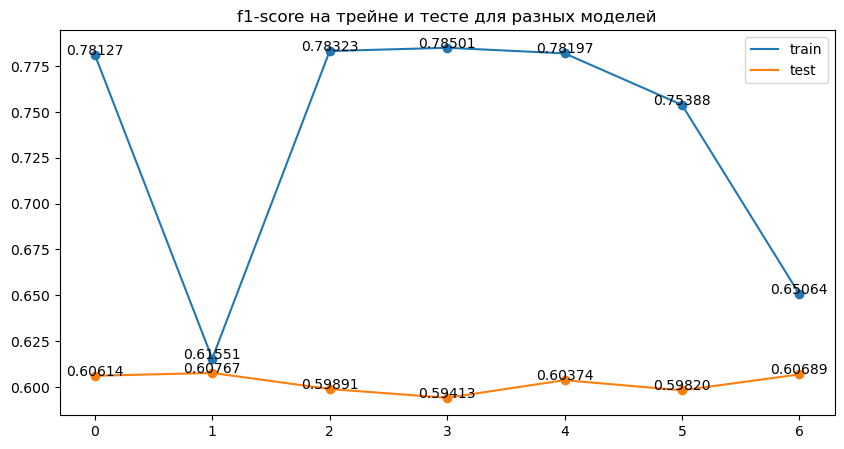

In [109]:
y_ = trials_df['number']

plt.figure(figsize=(10,5))
plt.plot(f1_opt_score_train_list, label='train')
plt.plot(f1_opt_score_test_list, label='test')
plt.scatter(y=f1_opt_score_train_list, x=y_)
plt.scatter(y=f1_opt_score_test_list, x=y_)

for i in range(len(y_)):
    plt.text(y_[i], f1_opt_score_train_list[i], f'{f1_opt_score_train_list[i]:.5f}', fontsize=10, ha='center')
    plt.text(y_[i], f1_opt_score_test_list[i], f'{f1_opt_score_test_list[i]:.5f}', fontsize=10, ha='center')

plt.legend()
plt.title('f1-score на трейне и тесте для разных моделей')
plt.show()

**Видим, что наименее переобученная под трейн модель с лучшим качеством на тесте получилась на второй итерации**

In [110]:
#trials_df.loc[1,:].to_frame()

**Подберем трешхолд для лучшей модели:**

In [111]:
estimator = CatBoostClassifier(**best_params_2, early_stopping_rounds=50)
estimator.fit(X_train, y_train)

0:	learn: 0.4956567	total: 8.09ms	remaining: 6.64s
1:	learn: 0.4137147	total: 15.2ms	remaining: 6.23s
2:	learn: 0.3690651	total: 22.4ms	remaining: 6.11s
3:	learn: 0.3401403	total: 29.4ms	remaining: 6.01s
4:	learn: 0.3264405	total: 36.6ms	remaining: 5.99s
5:	learn: 0.3171699	total: 44.1ms	remaining: 6s
6:	learn: 0.3097815	total: 51.3ms	remaining: 5.99s
7:	learn: 0.3047116	total: 58.4ms	remaining: 5.95s
8:	learn: 0.3035540	total: 65.3ms	remaining: 5.9s
9:	learn: 0.3010109	total: 72.9ms	remaining: 5.93s
10:	learn: 0.3004730	total: 80ms	remaining: 5.9s
11:	learn: 0.2990281	total: 87.1ms	remaining: 5.88s
12:	learn: 0.2984969	total: 94.6ms	remaining: 5.89s
13:	learn: 0.2982543	total: 101ms	remaining: 5.84s
14:	learn: 0.2977207	total: 108ms	remaining: 5.84s
15:	learn: 0.2976171	total: 117ms	remaining: 5.88s
16:	learn: 0.2967530	total: 124ms	remaining: 5.88s
17:	learn: 0.2965902	total: 131ms	remaining: 5.87s
18:	learn: 0.2963913	total: 138ms	remaining: 5.85s
19:	learn: 0.2961992	total: 146ms	r

173:	learn: 0.2907417	total: 1.4s	remaining: 5.22s
174:	learn: 0.2907217	total: 1.41s	remaining: 5.22s
175:	learn: 0.2906801	total: 1.42s	remaining: 5.21s
176:	learn: 0.2906661	total: 1.43s	remaining: 5.2s
177:	learn: 0.2906483	total: 1.43s	remaining: 5.2s
178:	learn: 0.2906235	total: 1.44s	remaining: 5.19s
179:	learn: 0.2906158	total: 1.45s	remaining: 5.19s
180:	learn: 0.2905991	total: 1.46s	remaining: 5.18s
181:	learn: 0.2905449	total: 1.47s	remaining: 5.17s
182:	learn: 0.2905249	total: 1.48s	remaining: 5.17s
183:	learn: 0.2905136	total: 1.49s	remaining: 5.16s
184:	learn: 0.2905023	total: 1.49s	remaining: 5.15s
185:	learn: 0.2904812	total: 1.5s	remaining: 5.14s
186:	learn: 0.2904410	total: 1.51s	remaining: 5.13s
187:	learn: 0.2904233	total: 1.52s	remaining: 5.13s
188:	learn: 0.2904003	total: 1.52s	remaining: 5.12s
189:	learn: 0.2903893	total: 1.53s	remaining: 5.11s
190:	learn: 0.2903784	total: 1.54s	remaining: 5.1s
191:	learn: 0.2903710	total: 1.55s	remaining: 5.09s
192:	learn: 0.290

342:	learn: 0.2884427	total: 2.79s	remaining: 3.9s
343:	learn: 0.2884298	total: 2.8s	remaining: 3.9s
344:	learn: 0.2884204	total: 2.81s	remaining: 3.89s
345:	learn: 0.2884129	total: 2.81s	remaining: 3.88s
346:	learn: 0.2884070	total: 2.82s	remaining: 3.87s
347:	learn: 0.2883958	total: 2.83s	remaining: 3.86s
348:	learn: 0.2883873	total: 2.84s	remaining: 3.86s
349:	learn: 0.2883823	total: 2.85s	remaining: 3.85s
350:	learn: 0.2883781	total: 2.85s	remaining: 3.84s
351:	learn: 0.2883709	total: 2.86s	remaining: 3.83s
352:	learn: 0.2883489	total: 2.87s	remaining: 3.82s
353:	learn: 0.2883449	total: 2.88s	remaining: 3.82s
354:	learn: 0.2883400	total: 2.89s	remaining: 3.81s
355:	learn: 0.2883192	total: 2.9s	remaining: 3.8s
356:	learn: 0.2883109	total: 2.9s	remaining: 3.79s
357:	learn: 0.2883051	total: 2.91s	remaining: 3.78s
358:	learn: 0.2883025	total: 2.92s	remaining: 3.77s
359:	learn: 0.2882953	total: 2.93s	remaining: 3.77s
360:	learn: 0.2882629	total: 2.94s	remaining: 3.76s
361:	learn: 0.2882

506:	learn: 0.2869682	total: 4.18s	remaining: 2.61s
507:	learn: 0.2869634	total: 4.19s	remaining: 2.6s
508:	learn: 0.2869585	total: 4.2s	remaining: 2.59s
509:	learn: 0.2869568	total: 4.21s	remaining: 2.58s
510:	learn: 0.2869514	total: 4.22s	remaining: 2.57s
511:	learn: 0.2869436	total: 4.22s	remaining: 2.56s
512:	learn: 0.2869302	total: 4.23s	remaining: 2.56s
513:	learn: 0.2869286	total: 4.24s	remaining: 2.55s
514:	learn: 0.2869244	total: 4.25s	remaining: 2.54s
515:	learn: 0.2869195	total: 4.26s	remaining: 2.53s
516:	learn: 0.2868992	total: 4.26s	remaining: 2.52s
517:	learn: 0.2868949	total: 4.27s	remaining: 2.52s
518:	learn: 0.2868899	total: 4.28s	remaining: 2.51s
519:	learn: 0.2868803	total: 4.29s	remaining: 2.5s
520:	learn: 0.2868694	total: 4.3s	remaining: 2.49s
521:	learn: 0.2868636	total: 4.31s	remaining: 2.48s
522:	learn: 0.2868464	total: 4.32s	remaining: 2.48s
523:	learn: 0.2868415	total: 4.32s	remaining: 2.47s
524:	learn: 0.2868387	total: 4.33s	remaining: 2.46s
525:	learn: 0.28

674:	learn: 0.2857608	total: 5.58s	remaining: 1.22s
675:	learn: 0.2857549	total: 5.58s	remaining: 1.21s
676:	learn: 0.2857517	total: 5.59s	remaining: 1.21s
677:	learn: 0.2857449	total: 5.6s	remaining: 1.2s
678:	learn: 0.2857392	total: 5.61s	remaining: 1.19s
679:	learn: 0.2857334	total: 5.62s	remaining: 1.18s
680:	learn: 0.2857249	total: 5.63s	remaining: 1.17s
681:	learn: 0.2857091	total: 5.63s	remaining: 1.17s
682:	learn: 0.2856998	total: 5.64s	remaining: 1.16s
683:	learn: 0.2856839	total: 5.65s	remaining: 1.15s
684:	learn: 0.2856757	total: 5.66s	remaining: 1.14s
685:	learn: 0.2856693	total: 5.67s	remaining: 1.13s
686:	learn: 0.2856653	total: 5.67s	remaining: 1.12s
687:	learn: 0.2856581	total: 5.68s	remaining: 1.11s
688:	learn: 0.2856528	total: 5.69s	remaining: 1.11s
689:	learn: 0.2856475	total: 5.7s	remaining: 1.1s
690:	learn: 0.2856453	total: 5.71s	remaining: 1.09s
691:	learn: 0.2856400	total: 5.71s	remaining: 1.08s
692:	learn: 0.2856356	total: 5.72s	remaining: 1.07s
693:	learn: 0.28

In [112]:
thresholds = np.arange(0.1, 0.9, 0.01)

f1_list = []
for threshold in tqdm(thresholds):
    predicted = (estimator.predict_proba(X_train)[:, 1] > threshold)
    
    f1 = f1_score(y_train, predicted)
    f1_list.append(f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 29.10it/s]


In [113]:
df = pd.DataFrame(list(zip(thresholds, f1_list)), columns=['Threshold', 'F1-Score'])
df[df['F1-Score'] == df['F1-Score'].max()]

,Threshold,F1-Score
23,0.33,0.660639


In [114]:
thld = round(df[df['F1-Score'] == df['F1-Score'].max()]['Threshold'].values[0], 3)

predicted = np.where(estimator.predict_proba(X_test)[:, 1] > thld, 1 , 0)
new_opt_f1_tshld = f1_score(y_test, predicted)
new_opt_f1_tshld

0.6488466334164589

## Заключение

### Было построено две модели - в одну передавали cat_features, в другой категориальные фичи закодировали таргет-энкодером  

### В результате:  
* модель с таргет-энкодером обучается быстрее, так как катбуст не тратит лишние ресурсы на обработку категориальных фичей
* модель с татаргет-энкодером дает чуть лучший f1 скор в базовом варианте без подобора гиперараметров, при том что по сути эта модель не требовала объемного EDA и ручных изменений в датасете (как, например: оставить в категориальном столбце один признак, а остальные заменить на "other")
* также модель без cat_features имеет чуть лучший скор после подбора порога и гиперарамметров, чем первая модель после этих же улучшений
* наилучшая модель - модель без cat_features, с применением target_encoder к категориальным признакам, а также подбором порога и гиперпараметров

In [115]:
rows=['f1-score на тесте (базовая модель)',
      'f1-score на тесте после подбора порога (базовая модель)',
      'f1-score на тесте после подбора порога и гиперпараметров',
      'f1-score на тесте для модели без cat_features',
      'f1-score на тесте после подбора порога для модели без cat_features',
      'f1-score на тесте после подбора порога и гиперпараметров для модели без cat_features']

values = [base_f1 , 
          base_f1_tshld, 
          opt_f1_tshld,
          base_f1_new,
          new_base_f1_tshld,
          new_opt_f1_tshld]

pd.DataFrame(values, rows, columns=['value'])

,value
f1-score на тесте (базовая модель),0.607873
f1-score на тесте после подбора порога (базовая модель),0.646020
f1-score на тесте после подбора порога и гиперпараметров,0.647707
f1-score на тесте для модели без cat_features,0.609187
f1-score на тесте после подбора порога для модели без cat_features,0.646675
f1-score на тесте после подбора порога и гиперпараметров для модели без cat_features,0.648847
